In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [2]:
random_state = 123*987*4-1
models_to_average = 50

In [3]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp1.9.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp1.9.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp1.9.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp1.9.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [4]:
len(synt_data_cerebras.columns)

18

In [5]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [6]:
cols = real_dataset.columns

In [7]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [8]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [9]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [10]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [11]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [12]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [13]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [14]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [15]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [16]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [17]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [18]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [19]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [20]:
print(real_dataset.isna().sum().sum())

0


In [21]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

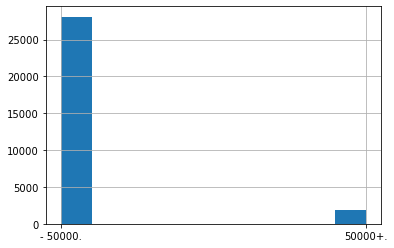

In [22]:
real_dataset['target'].hist()

In [23]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


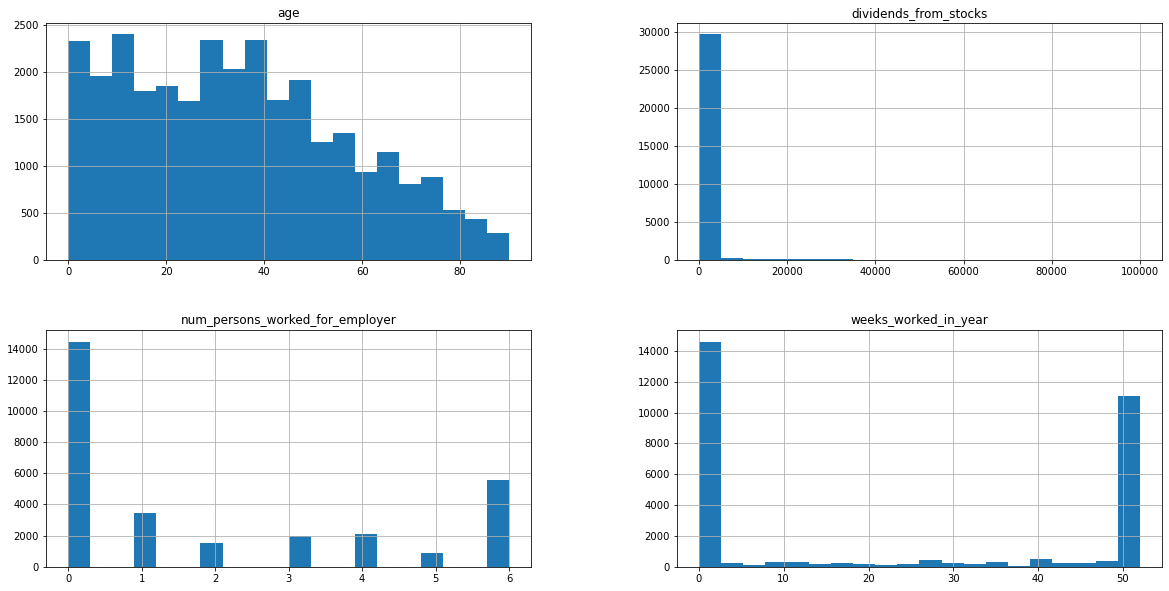

In [24]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

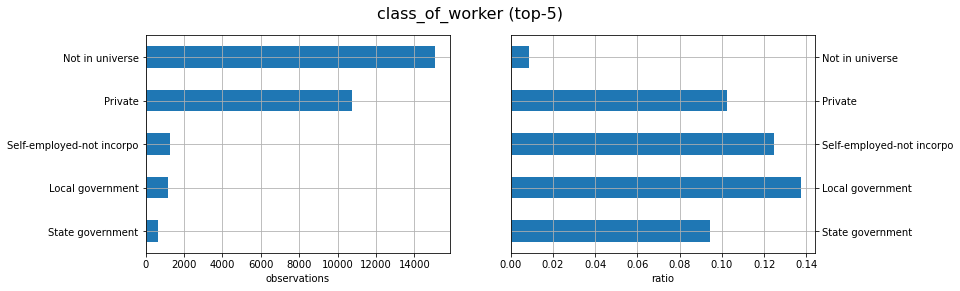

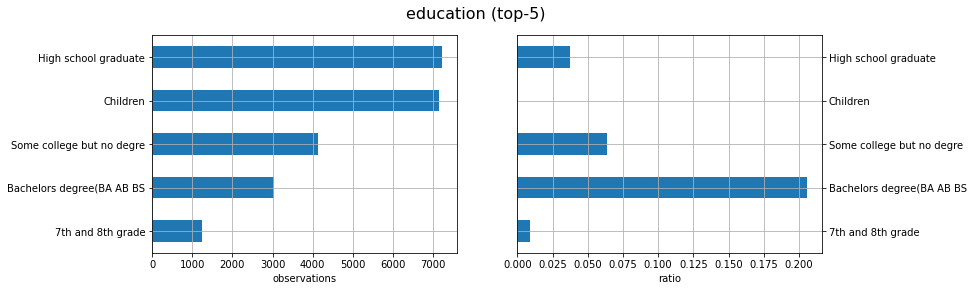

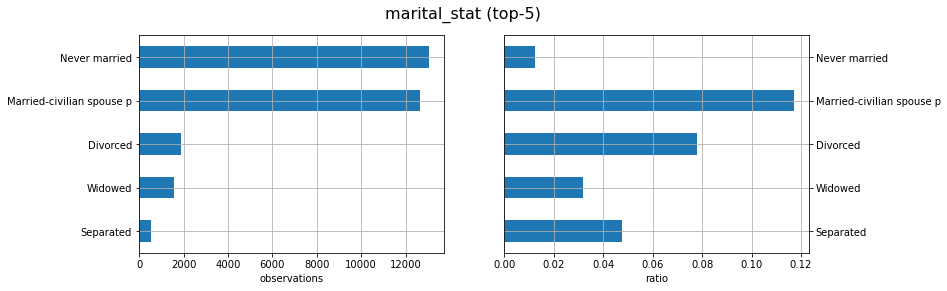

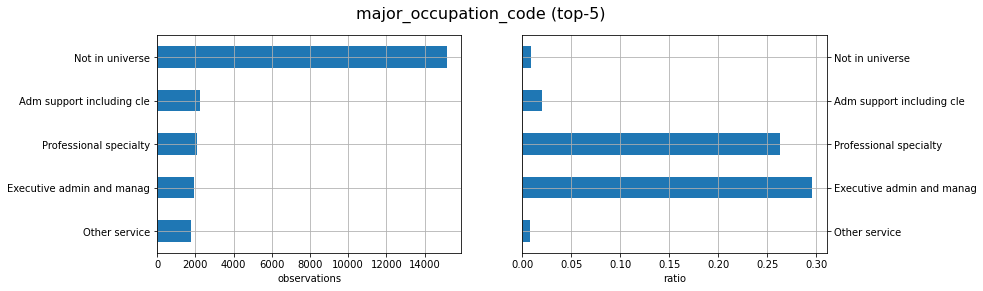

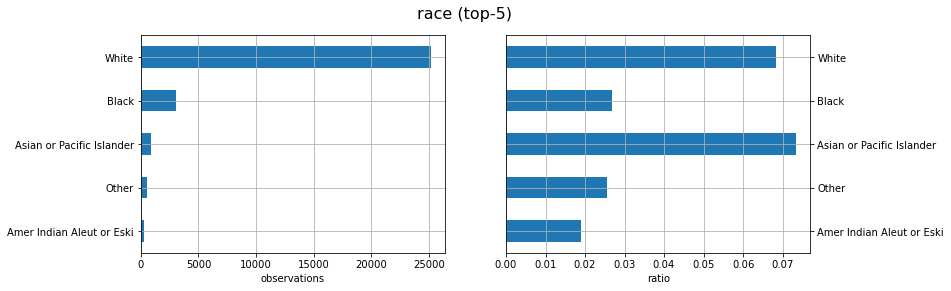

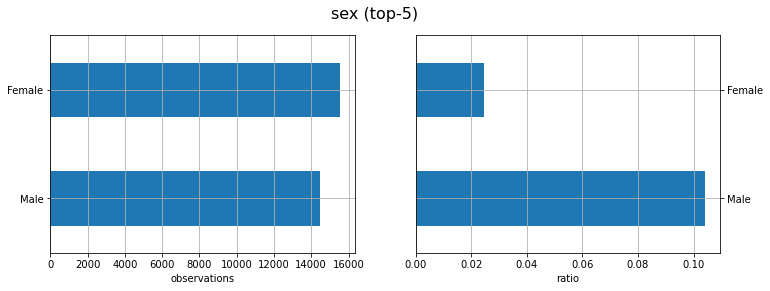

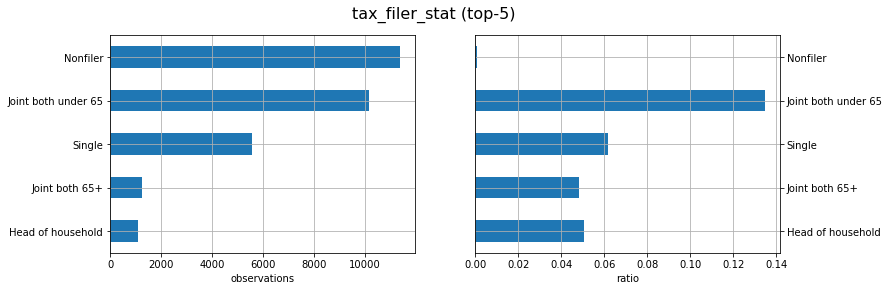

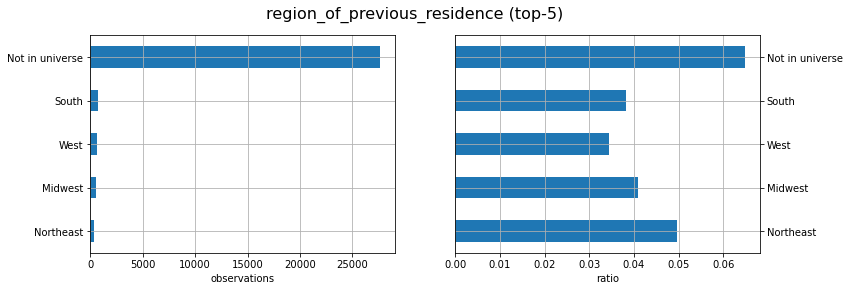

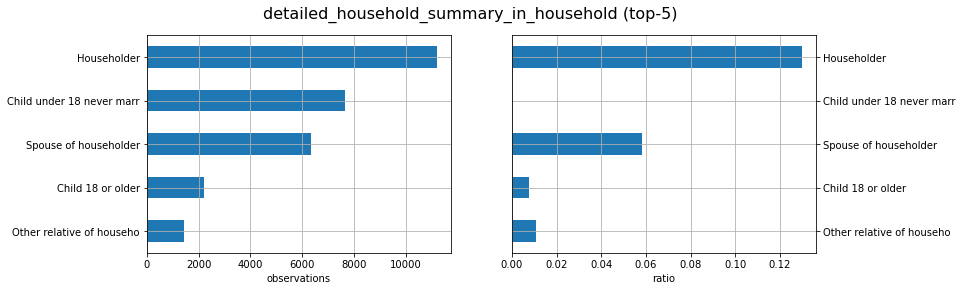

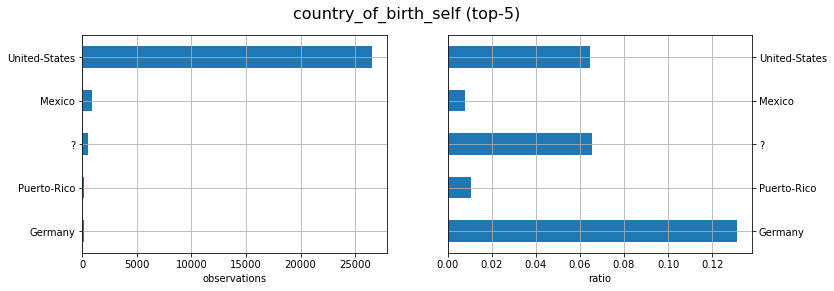

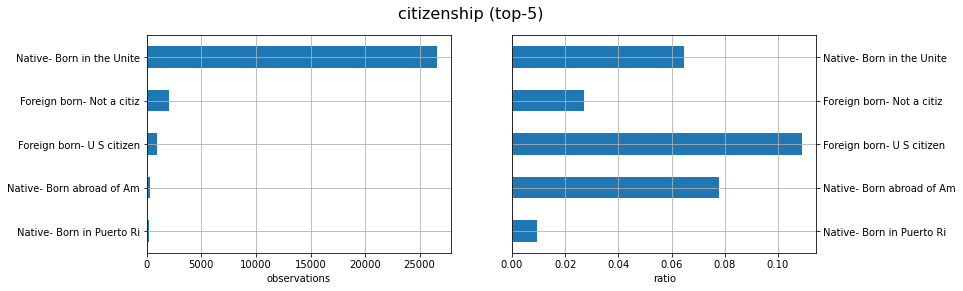

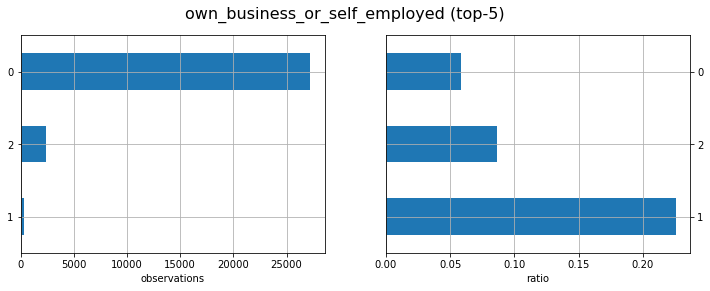

In [25]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [26]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count   30000.000000           2.999900e+04                     30000.000000   
mean       85.337300           4.008365e+06                        29.073767   
std      3241.385024           6.352771e+08                      1001.331252   
min         0.000000          -5.000000e+02                         0.000000   
25%        26.000000           0.000000e+00                         1.000000   
50%        39.000000           2.500000e+01                         3.000000   
75%        55.000000           1.068000e+03                         5.000000   
max    430000.000000           1.100000e+11                     99999.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                       71.170233             56.036467  
std                      2685.881817           2248.395165  
min                        -2.000000              0.000000  
25%                         0.000000              3.000000  
50%                         0.000000             25.000000  
75%                         1.000000             46.000000  
max                    270000.000000         370000.000000

In [27]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

4
age                                        0
class_of_worker                            1
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      1
tax_filer_stat                             0
region_of_previous_residence               2
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [28]:
synt_data_distilgpt2['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

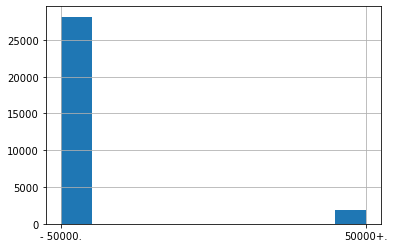

In [29]:
synt_data_distilgpt2['target'].hist()

In [30]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


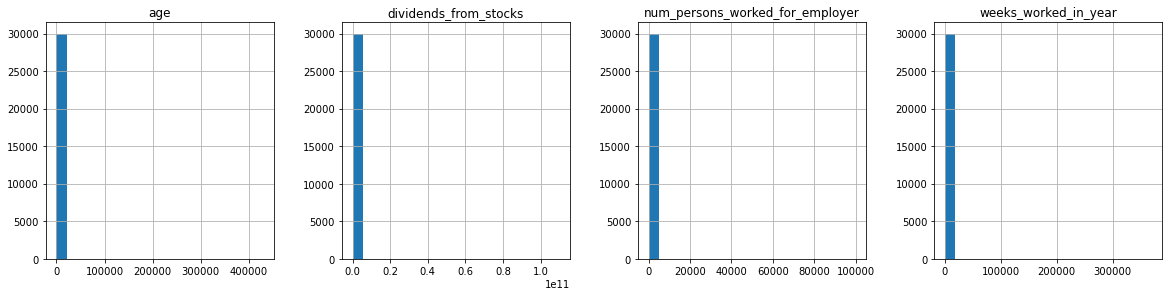

In [31]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

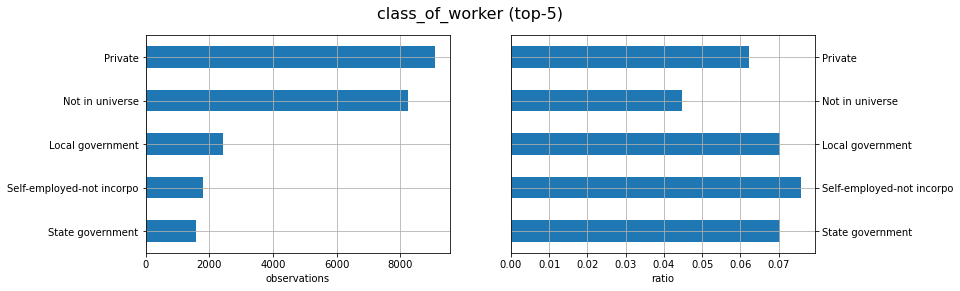

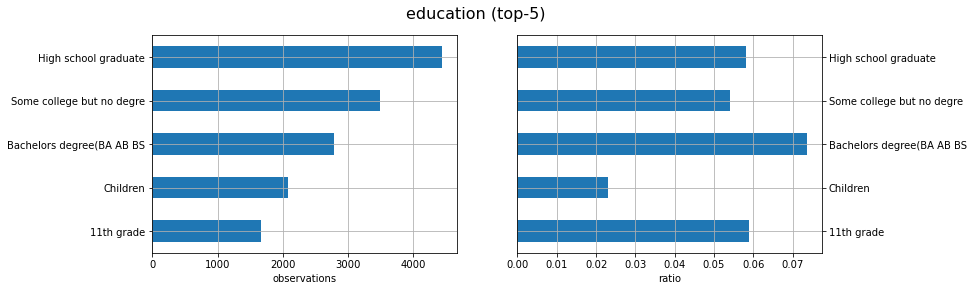

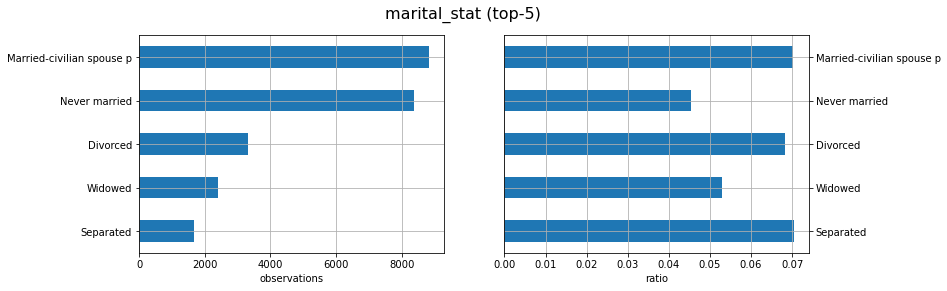

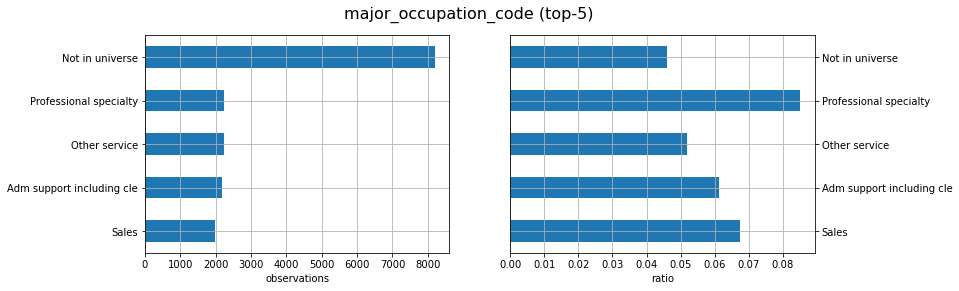

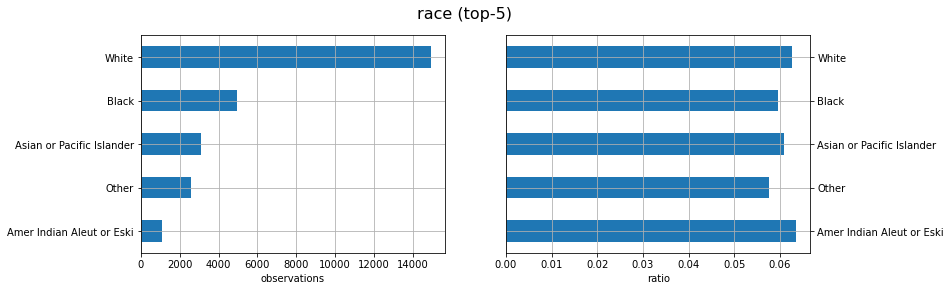

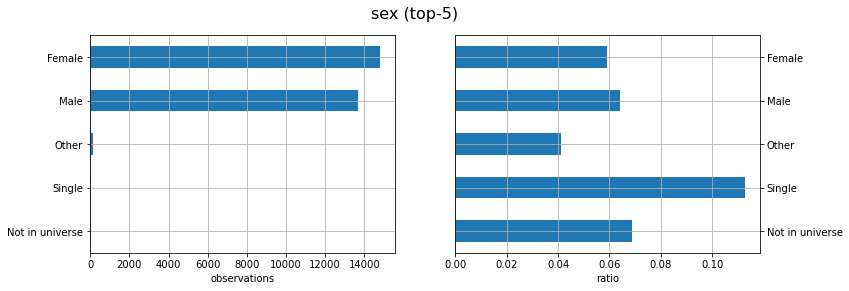

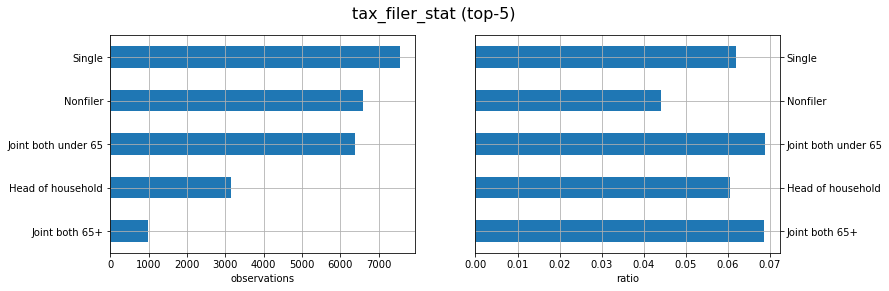

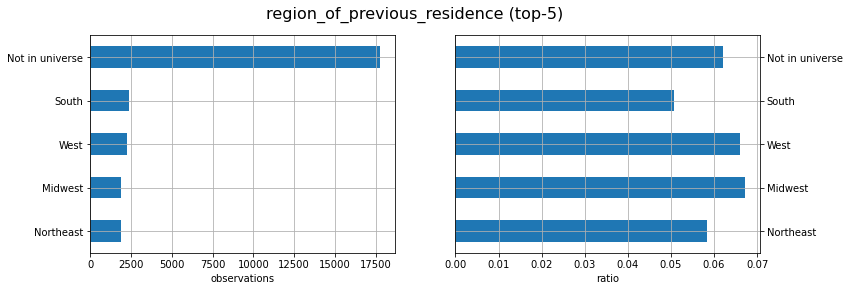

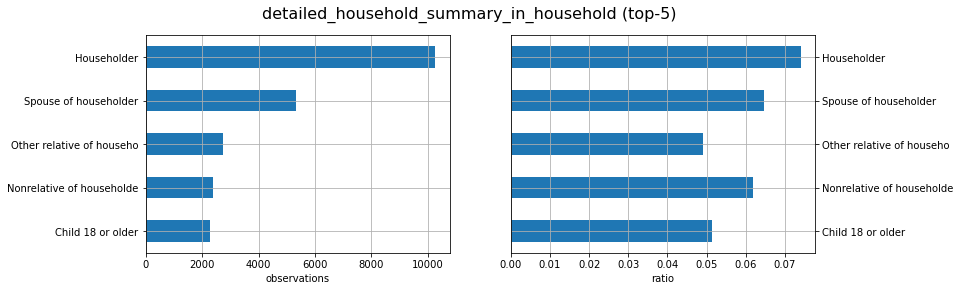

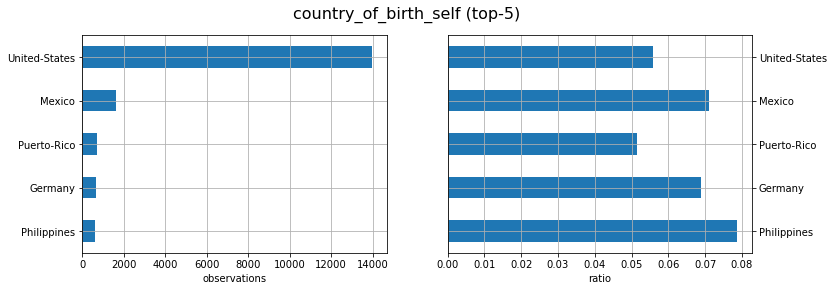

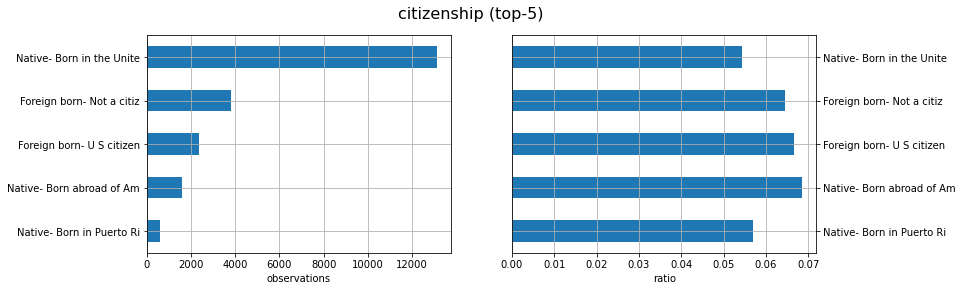

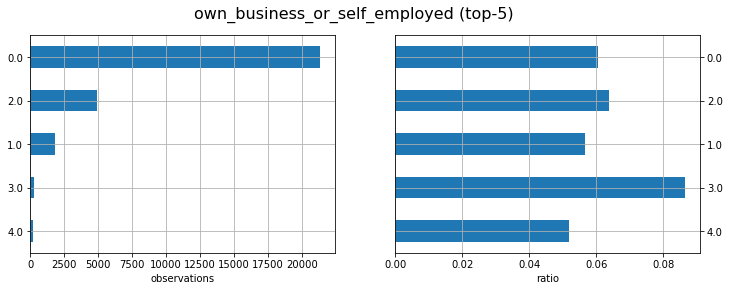

In [32]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [33]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           3.000000e+04                     30000.000000   
mean      43.513000           4.401033e+03                         6.907333   
std      340.372623           3.058209e+05                       578.584936   
min        0.000000           0.000000e+00                         0.000000   
25%       25.000000           0.000000e+00                         0.000000   
50%       38.000000           0.000000e+00                         2.000000   
75%       54.000000           5.000000e+02                         5.000000   
max    38000.000000           5.065898e+07                     99999.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                       78.570533             31.779432  
std                      6096.530771            336.272149  
min                         0.000000              0.000000  
25%                         0.000000              1.000000  
50%                         0.000000             24.000000  
75%                         1.000000             45.250000  
max                    905981.000000          43000.000000

In [34]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [35]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

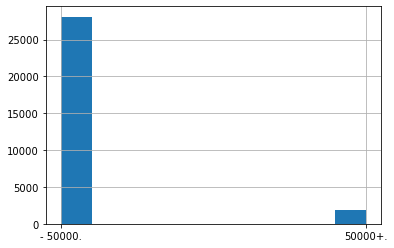

In [36]:
synt_data_gpt2xl['target'].hist()

In [37]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.29% and 93.71%


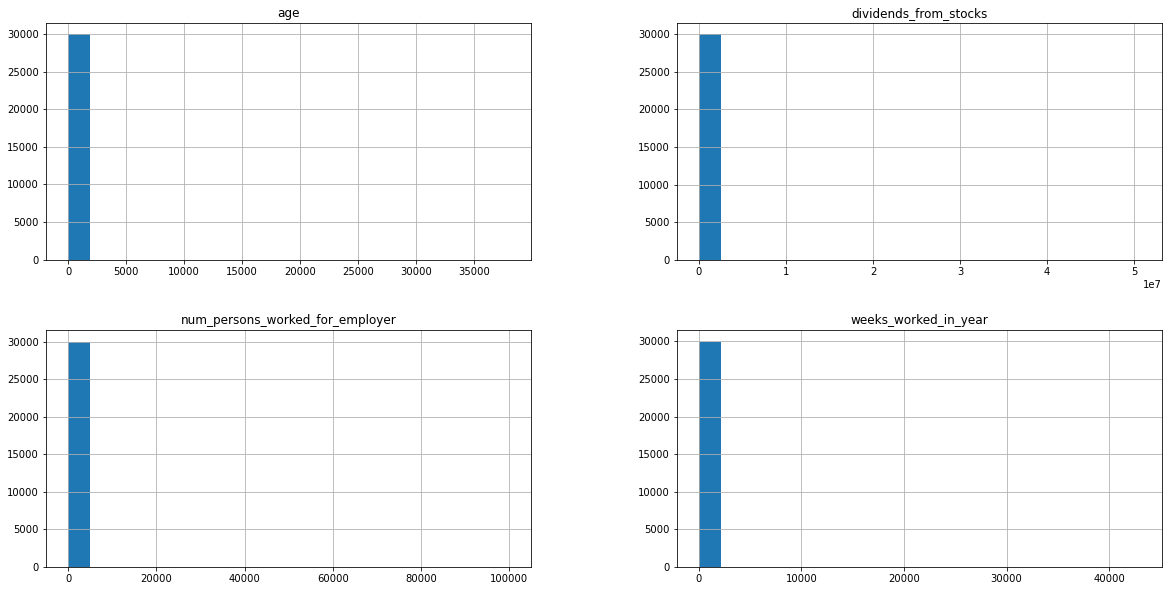

In [38]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

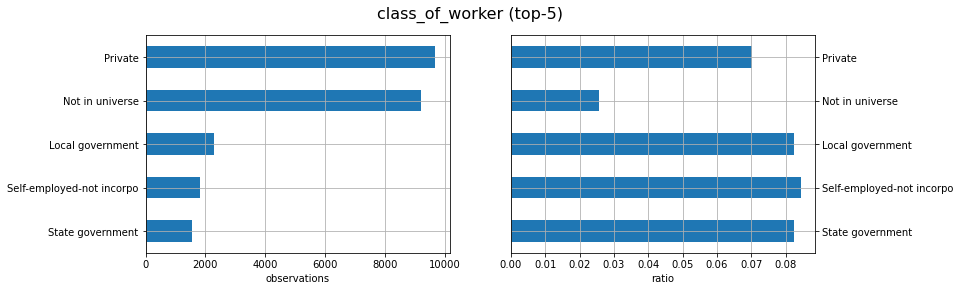

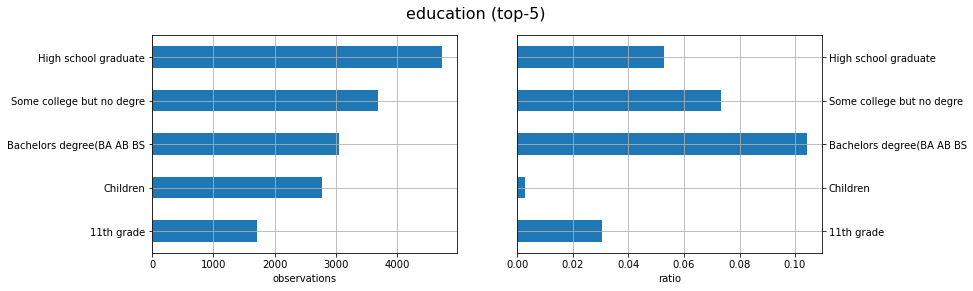

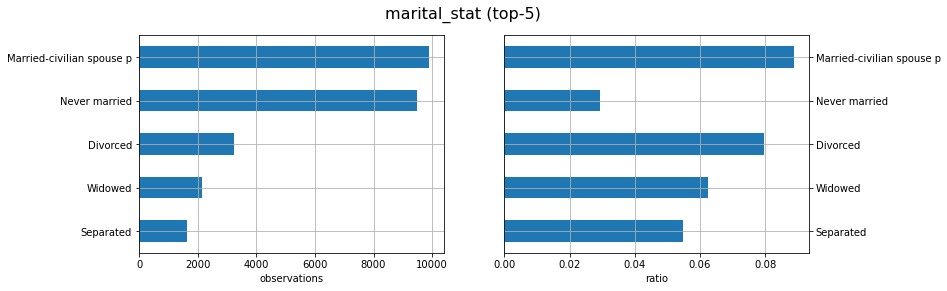

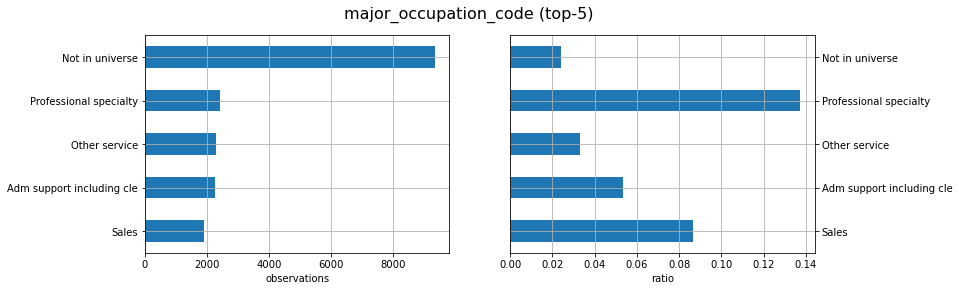

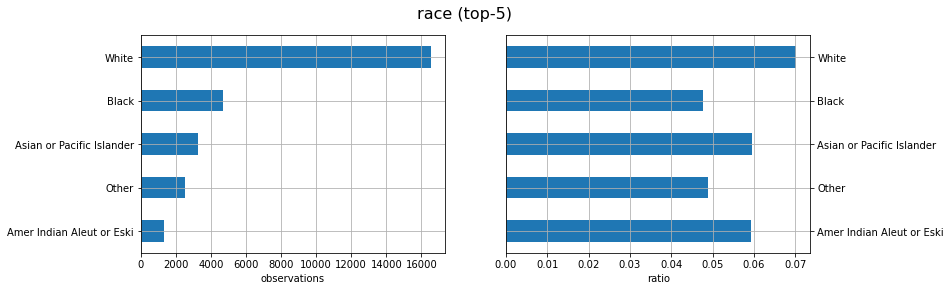

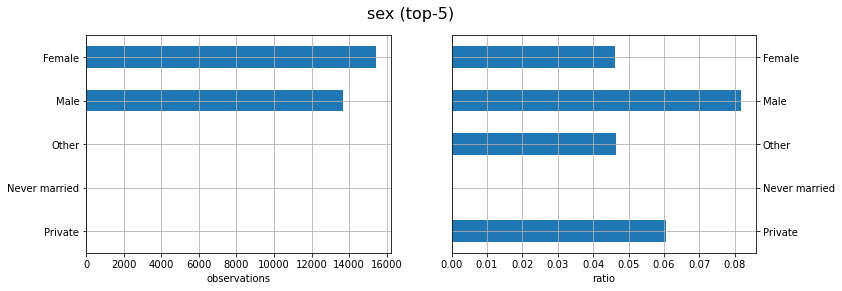

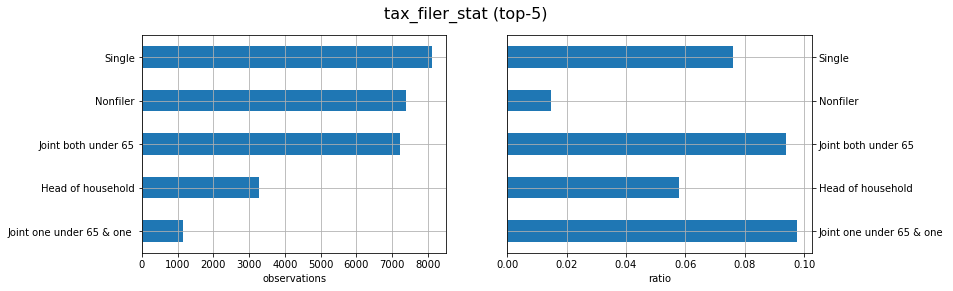

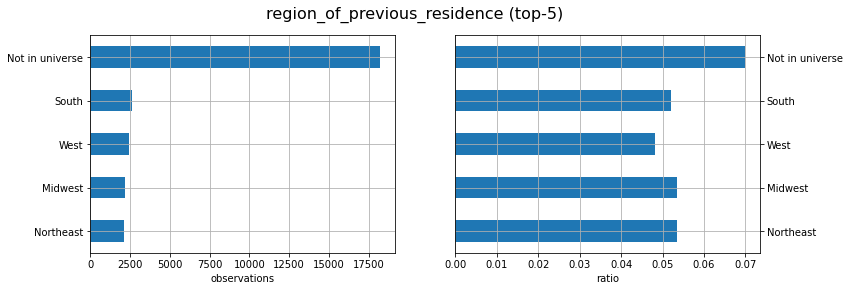

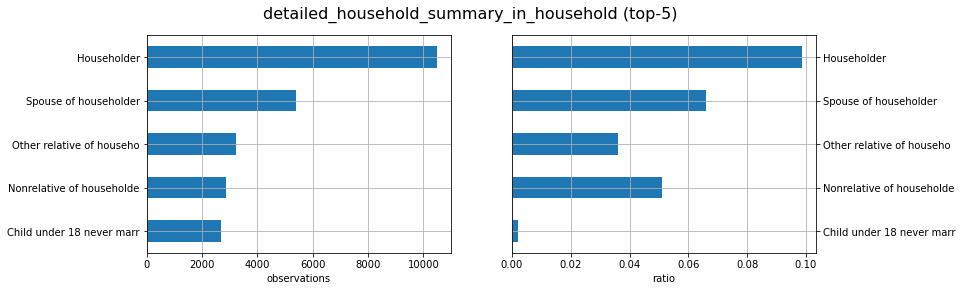

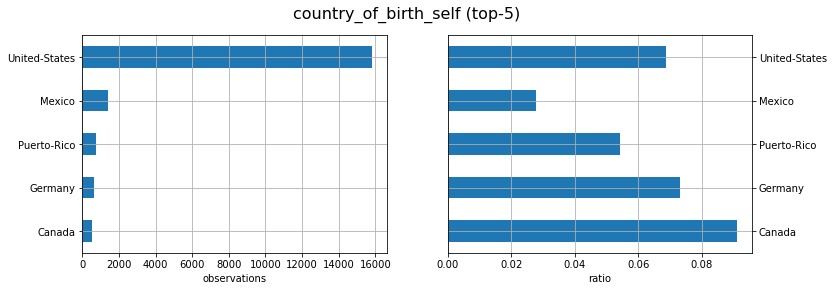

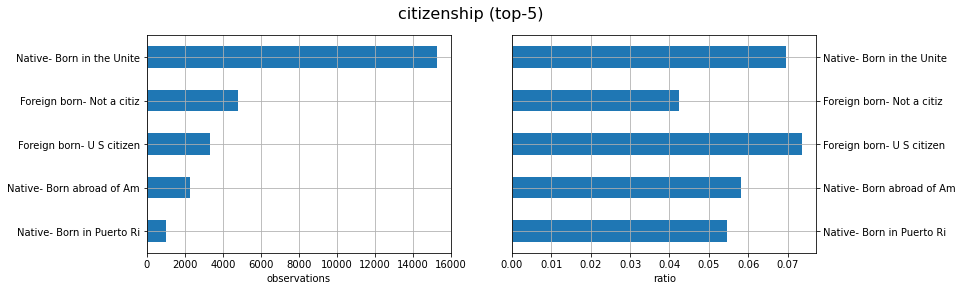

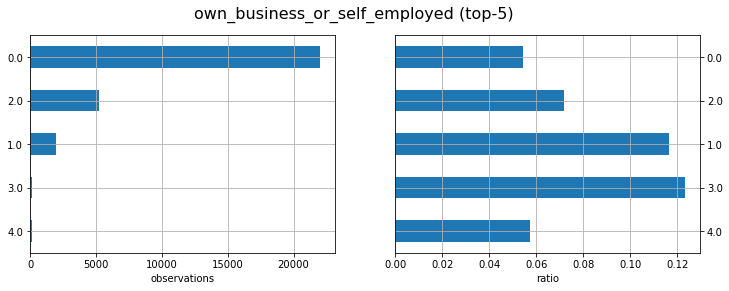

In [39]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [40]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           3.000000e+04                     30000.000000   
mean      46.276900           2.681699e+03                         6.095233   
std      469.735683           8.459722e+04                       296.409293   
min        0.000000           0.000000e+00                        -4.000000   
25%       25.000000           0.000000e+00                         0.000000   
50%       38.000000           0.000000e+00                         2.000000   
75%       53.000000           5.000000e+02                         5.000000   
max    78000.000000           1.098706e+07                     50000.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                       64.267233             36.456233  
std                      2471.975145            622.390160  
min                         0.000000              0.000000  
25%                         0.000000              1.000000  
50%                         0.000000             25.000000  
75%                         1.000000             46.000000  
max                    320000.000000          70000.000000

In [41]:
print(synt_data_cerebras.isna().sum().sum())

0


In [42]:
synt_data_cerebras['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

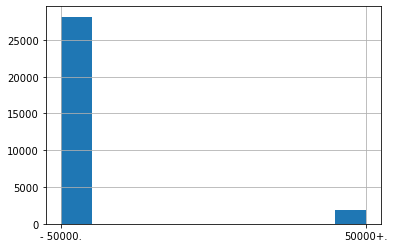

In [43]:
synt_data_cerebras['target'].hist()

In [44]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.17% and 93.83%


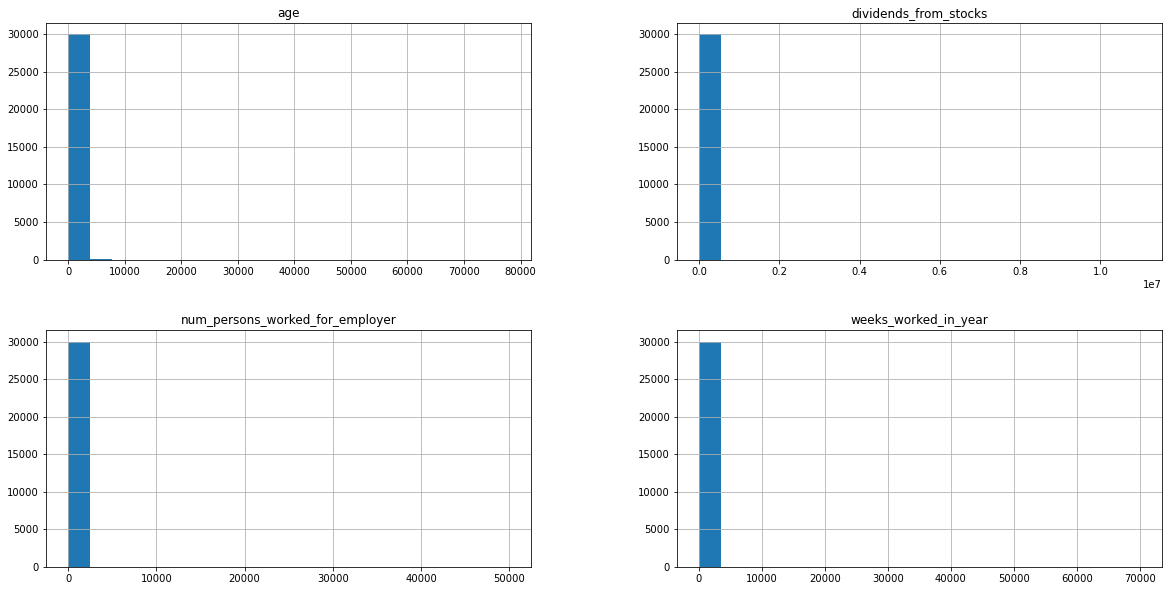

In [45]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

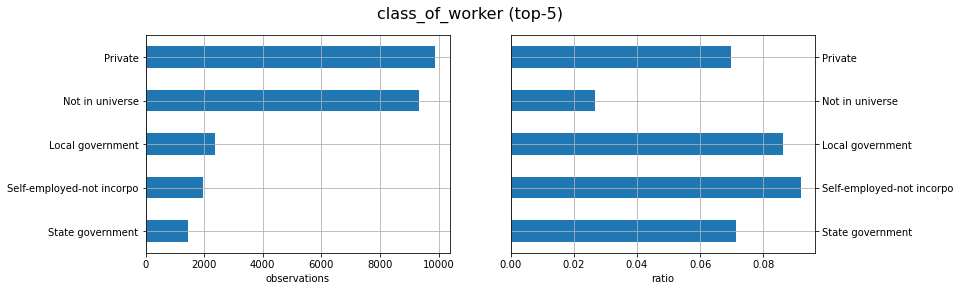

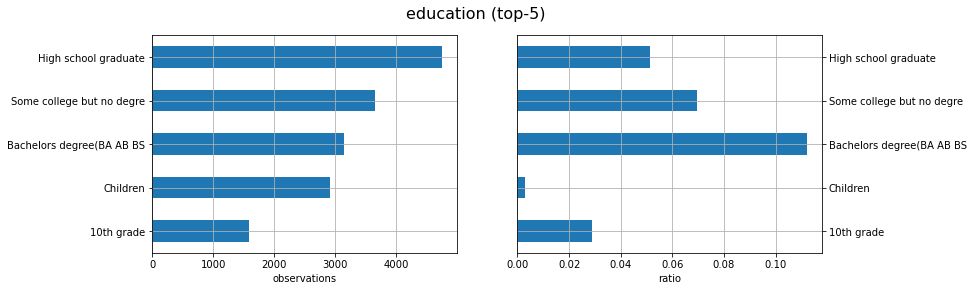

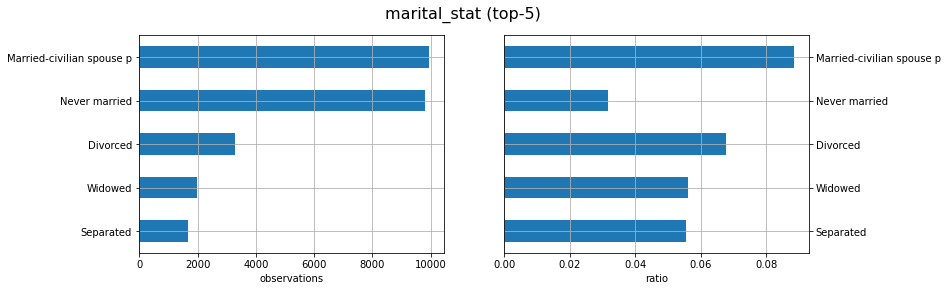

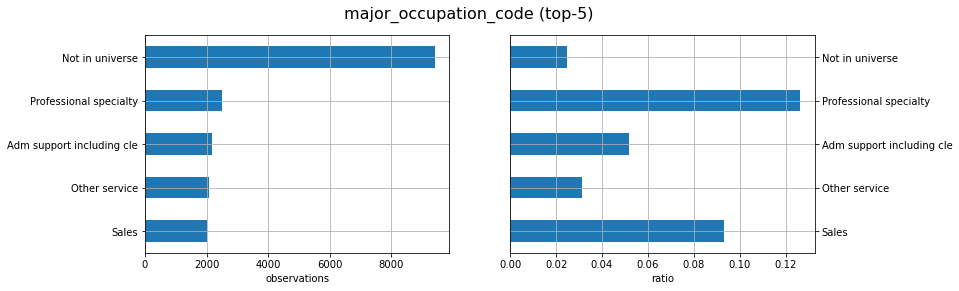

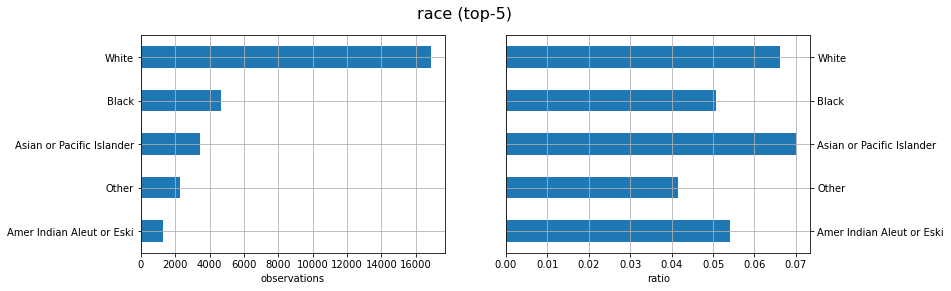

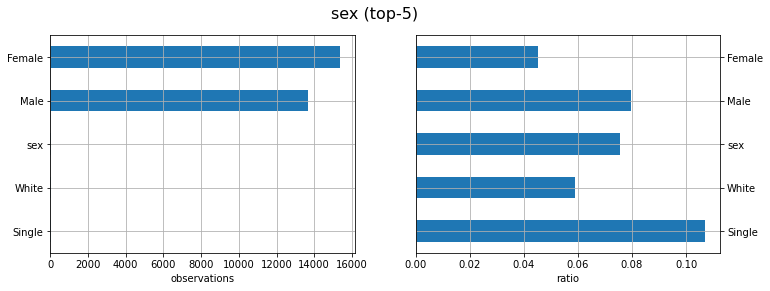

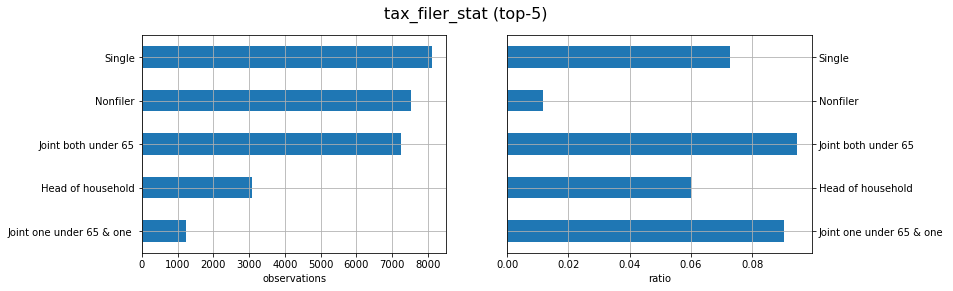

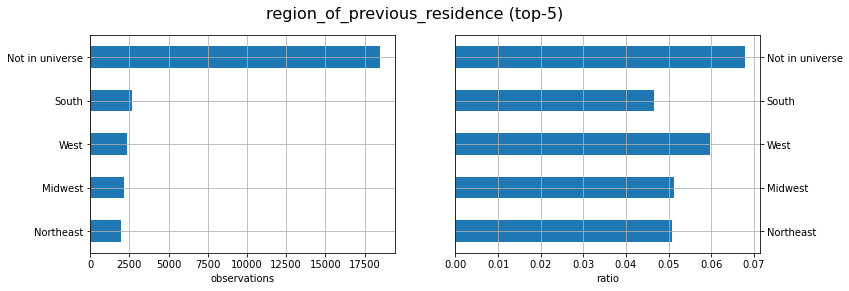

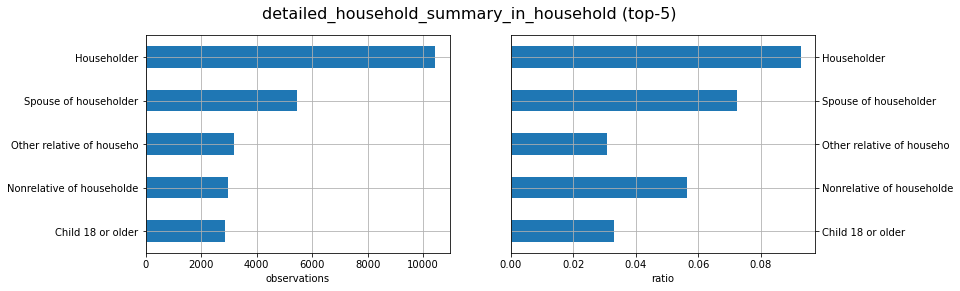

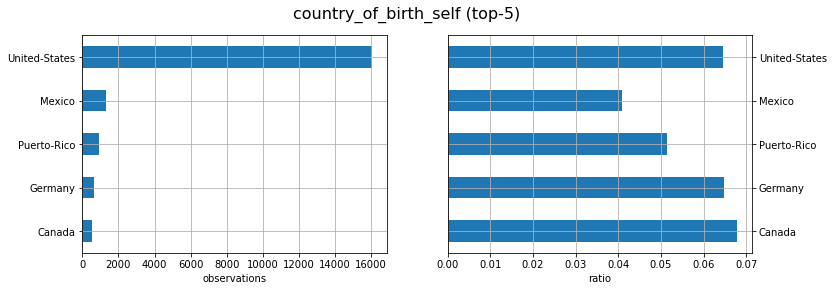

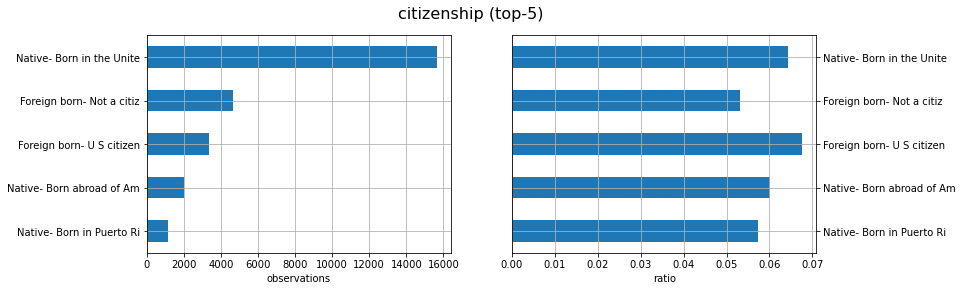

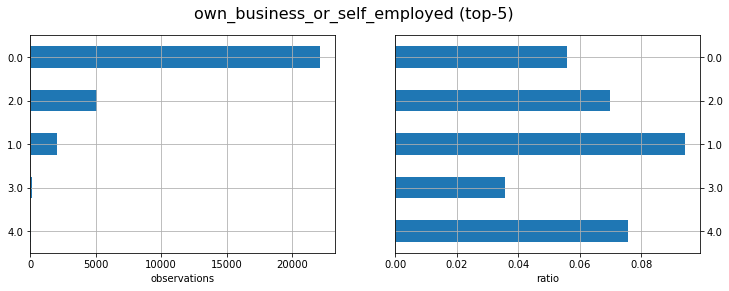

In [46]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [47]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           3.000000e+04                     30000.000000   
mean      42.713667           1.068192e+05                         3.278100   
std      404.626257           1.733221e+07                        13.884948   
min        0.000000           0.000000e+00                         0.000000   
25%       25.000000           0.000000e+00                         0.000000   
50%       38.000000           0.000000e+00                         2.000000   
75%       53.000000           5.000000e+02                         5.000000   
max    65000.000000           3.000956e+09                      1000.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                       10.800333             25.409733  
std                       726.324645             66.049482  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             24.000000  
75%                         1.000000             45.000000  
max                     99999.000000           5250.000000

In [48]:
print(synt_data_phi.isna().sum().sum())

0


In [49]:
synt_data_phi['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

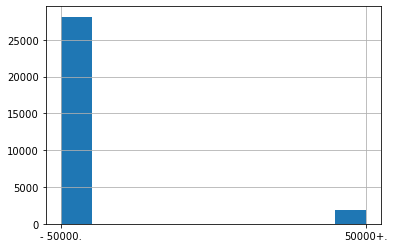

In [50]:
synt_data_phi['target'].hist()

In [51]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.26% and 93.74%


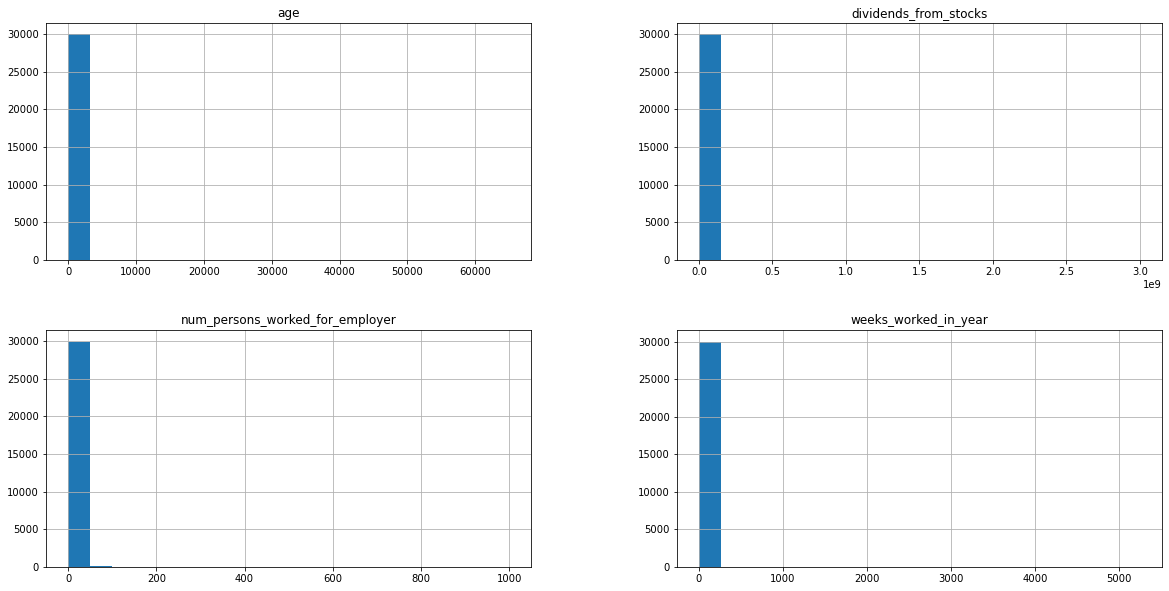

In [52]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

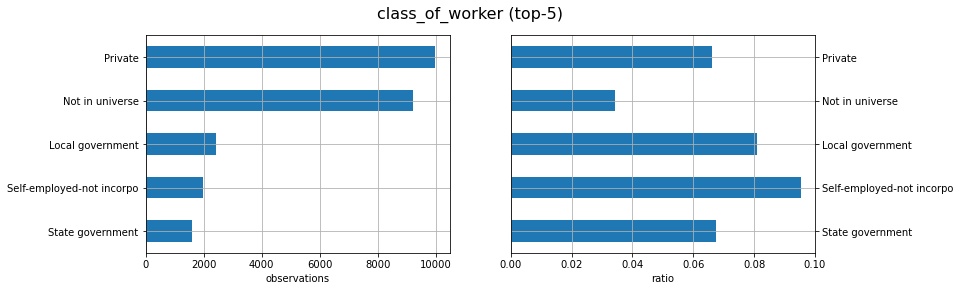

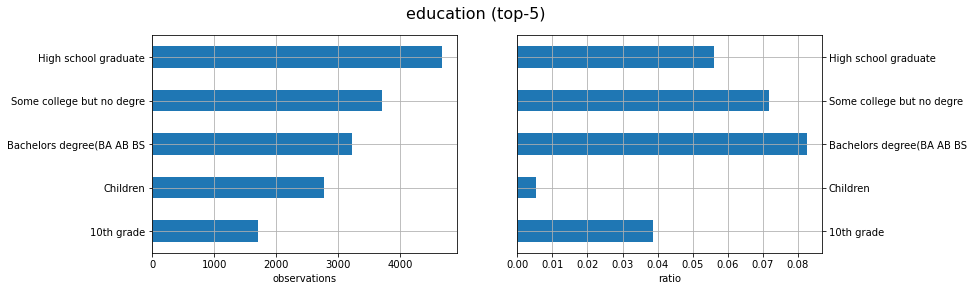

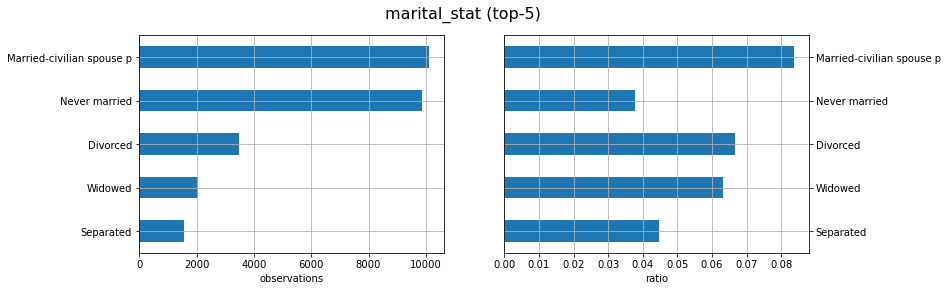

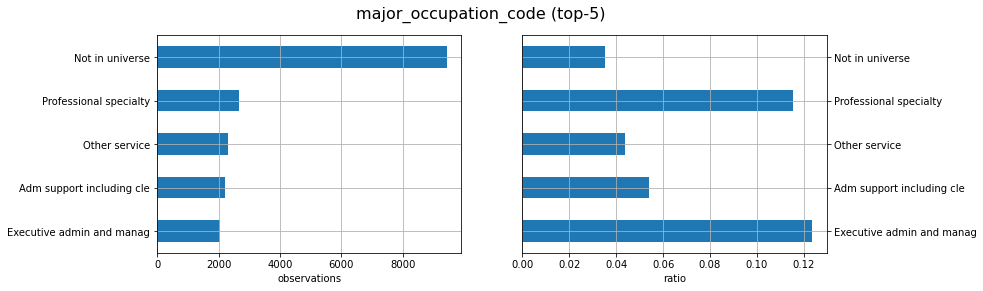

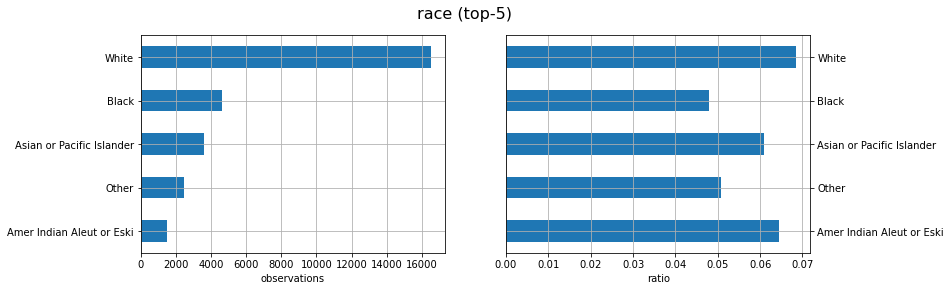

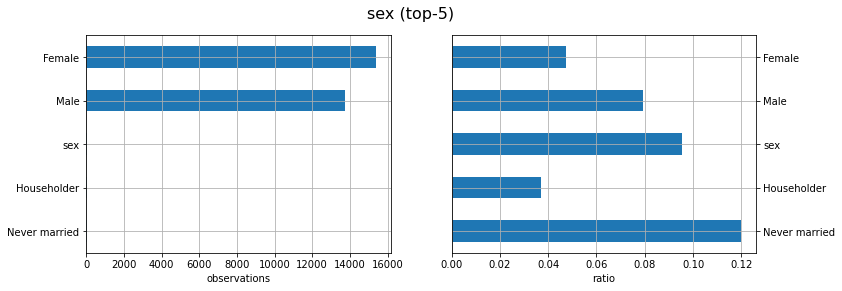

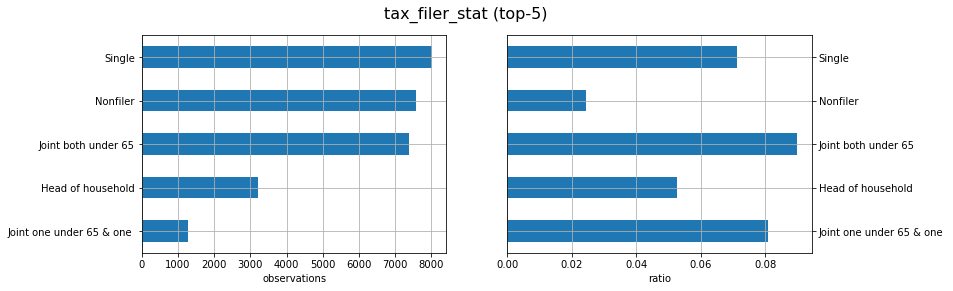

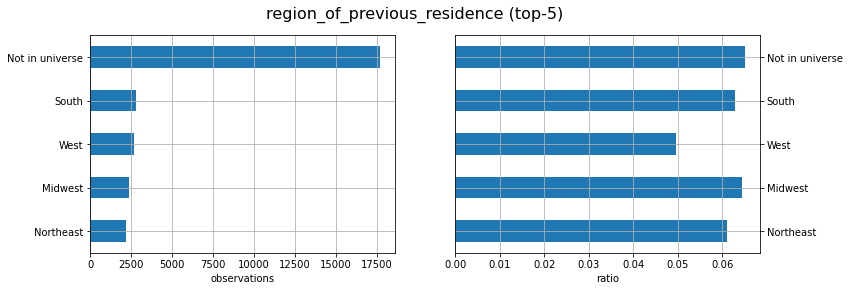

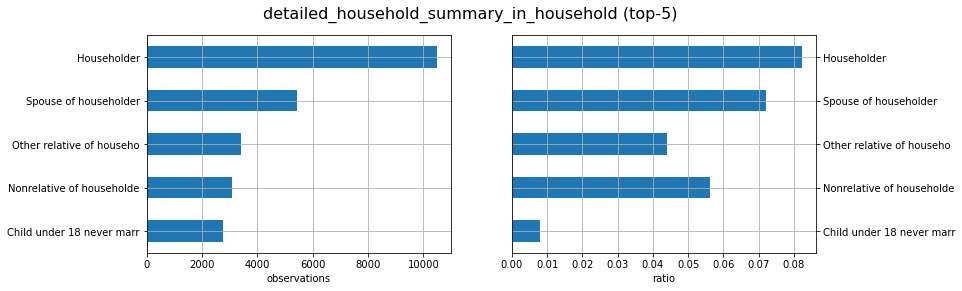

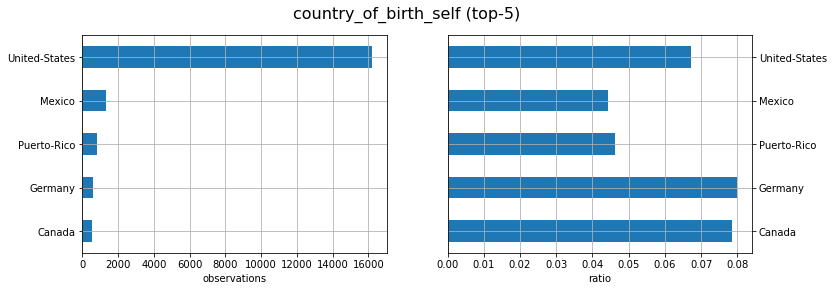

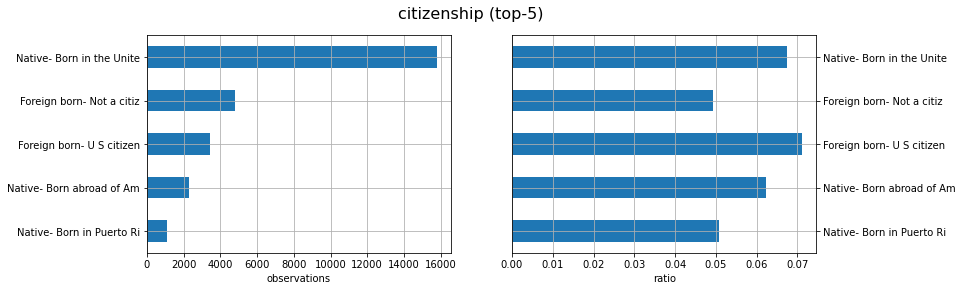

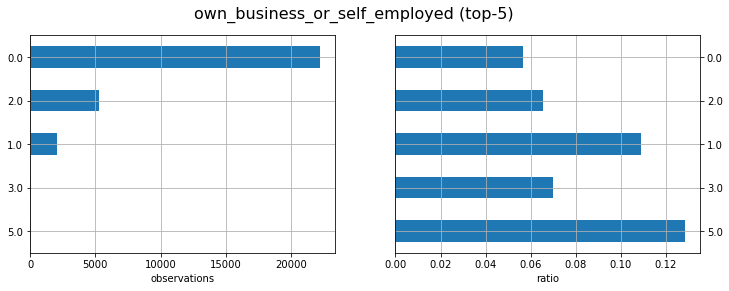

In [53]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [54]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [55]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [56]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

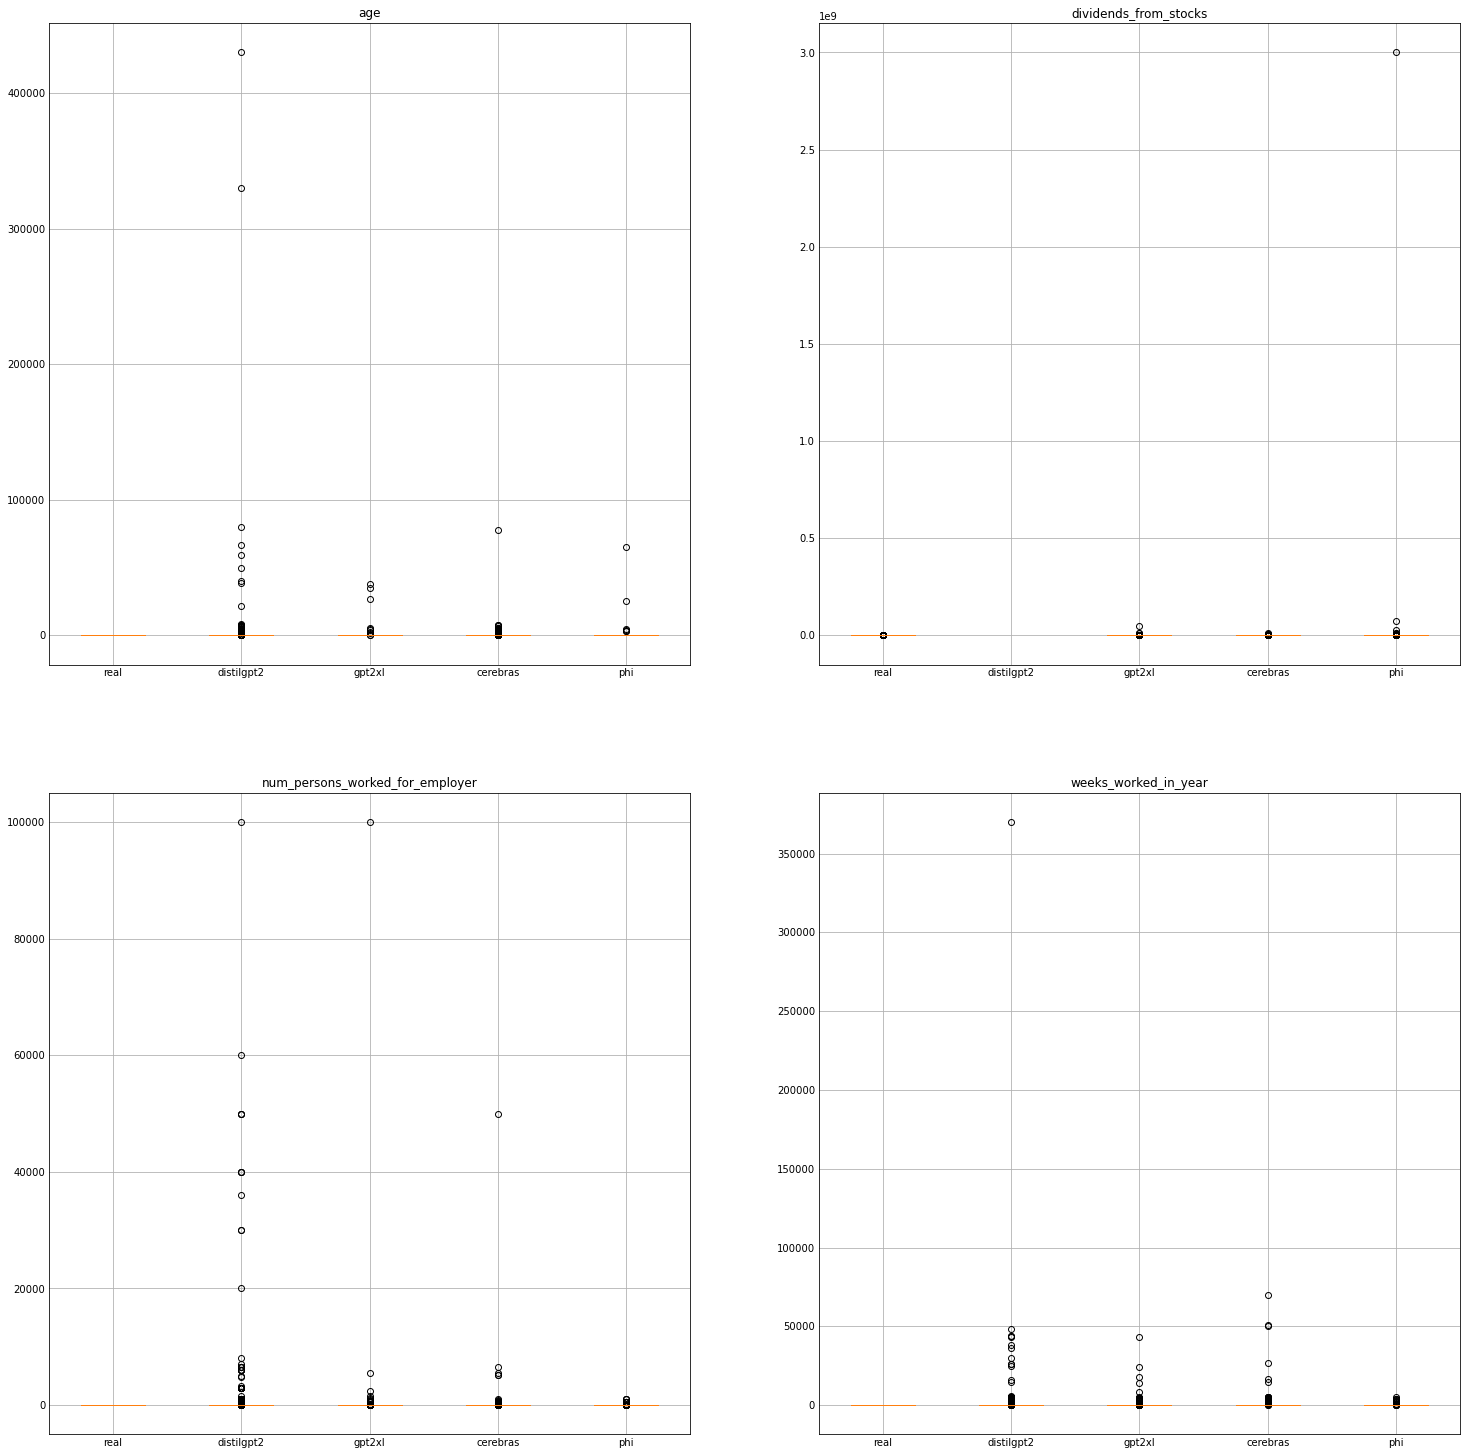

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [58]:
to_encode = [i for i in categs]

In [59]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [60]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [61]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [62]:
real_data = real_dataset.copy()

In [63]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [64]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [65]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [66]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [67]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [68]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [69]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [70]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [71]:
to_encode_real = to_encode.copy() 

In [72]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [73]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [74]:
to_encode_real

[]

In [75]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [76]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [77]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

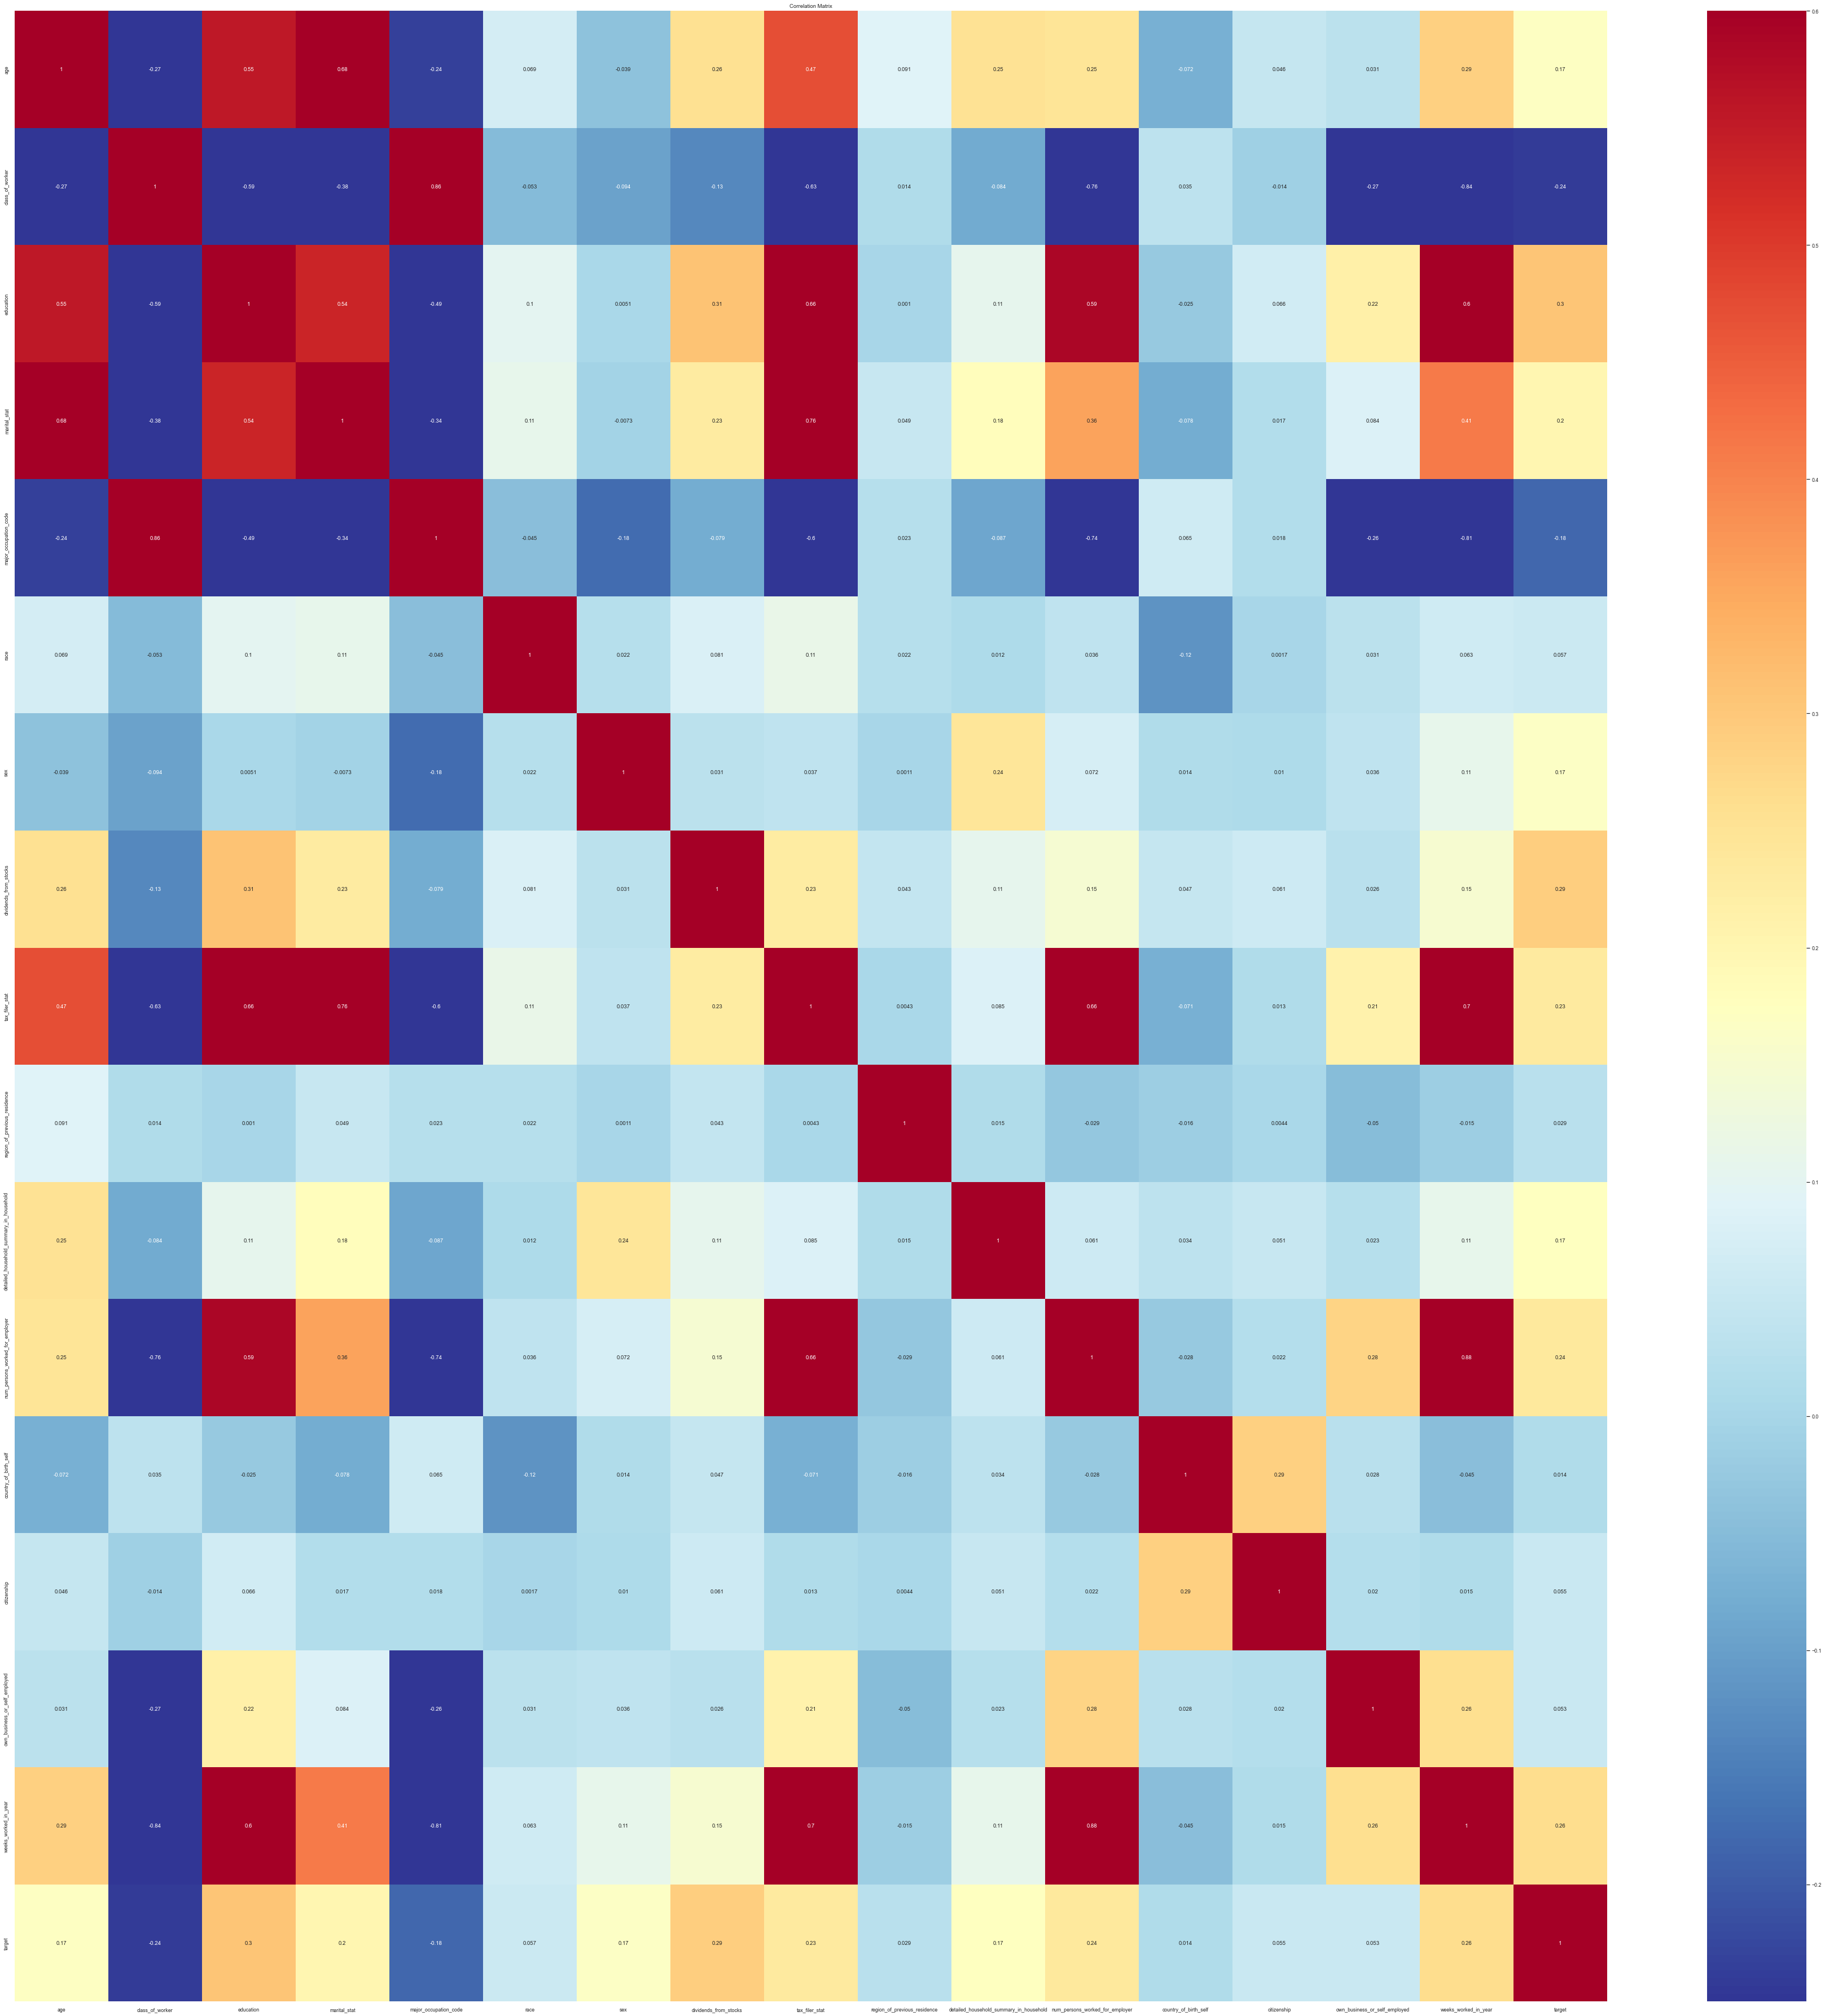

In [78]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [79]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [80]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [81]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [82]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [83]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [84]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [85]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 359 ms
Wall time: 372 ms


In [86]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [87]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.3s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [88]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8464060619430963
LogisticRegression(C=0.1, solver='saga')


In [89]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [90]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [91]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [92]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [93]:
synt_data = synt_data_distilgpt2.copy()

In [94]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [95]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [96]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [97]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [98]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [99]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Masters degree(PhDPhD School degree(PhD Sack D)'
 'Associates degree-academic program' '1st 2nd 3rd or 4th grade' ...
 'Associates degree-occup Prof school including college but major 9th grade'
 'Handgun' 'Joint both one but no degree'] 2332


In [100]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

Masters degree(PhDPhD School degree(PhD Sack D)
Adm support including Bachelors degree(BA AB BS)
Nonfiler
Not a Doctorate degree(PhD EdD)
Self-employed-employed-not incorporated
10st grade
Masters degree(MA MS MEng MEd MSW Sales
Doctorate degree(PhD Ed Sales)
1st 6th and 8th grade
Elpajar or F-occup /vocational
9th grade no diploma
Foreign born- Not a citizen of U S
Associates degree-thlorspmblors & inspctrs
Local government
Prof school program
High school but no degree
Joint both class under 65
High-interest class
2-
Child 18th grade
Associates degree(occup /vocational
13th and 8th grade
21st
Doctorate degree(PhD Eddy)
Prof school under college
Associates degree-oranges
Black
2nd 3rd or 4th grade
Executive Doctor(PhD EdD)
12th grade never diploma
Not in universe
Joint JD S & M.
14th grade no diploma
25th grade
Private
class Bachelors degree (MD)
Bachelors degree(BA AB degree)
House class
Secondary school graduate
5th or 6th grade)
Prof school degree (incorporated
Adm support including

12th grade Children
17th or 18th grade
0+
MBA
Prof school degree (MD DDS DVM major /vocational
Associates degree-stat
Single maltose 2nd etc
40 Bachelors degree(BA AB BS)
Outlier
Bachelors degree(BA AB LLB JD)
Less than one grade
11 - 15
44 or 48
Less than 5th grade
2nd or 3rd grade
15st grade
Less than 1st grader
Masters degree(MA MS MEng MEd MSD)
Associates degree-of major /vocational
- 50
Associates degree-occup /vocmblrs
Out-of_previous edit
5th grade
Bachelors degree(occup /vocational)
1st or 6th grade
Technicians or related support
Self-employed-academic
Out-U S (PhD Wayne
Masters degree(occup /vocational
1st 2nd or 3rd grade
7 graduate
Less High school graduate
4th or 50 grade
Outlying
12th grade school but no diploma
High grade
Prof school graduate
Associates degree-at program
Some
Amer Indian Aleut orut Pacific Islander
1st 2nd 3rd line
40
Child 18 in the United States
11 1st 2nd 3rd or householder
9th grade but no diploma
Doctorate degree(PhD/PhD EdD)
Prof school degree (MD D

Children 15
Less than 6th grade
1st 2rd or 5th grade
75th or older
10th grade Uml
Associates degree-not degree
Bachelors MBA(BA AB BS)
10th grade+
Some 55 graduate
Technicians degree (MD DDS DVM CO BVI / JD)
BSc
Prof school degree ((PSU MS MEng MEd MSW MBA)
3rd or 4th grade & 5th grade
Doctorate degree(PhD school graduate)
5000+.
Associates degree-occupepental engineer
Prof school degree (MD DDS DVM & HVM
Masters degree(MA MS MEng JD)
Prof school level
Prof schoolboy
Doctorate degree(Ph.D EdD)
Associates degree-spouse absent
1st 2nd 5th etc
college or own- U S citizen by naturalization
1st 2nd 3rd or 4th grade no diploma
5th or Less MEng MEd MSW MBA
5th or 7th grade
Bachelors degree(BA AB LL)
Professional degree (PhD EdD)
Head Coach graduate
Doctorate(PhD EdD)
Associates degree-
Doctorate degree(PhD Ed MS Doctorate
Doctorate degree(MD DDS DVM LLB JD)
Masters college but no degree
Less than 1st 6th and 8th grade
6th or seventh grade
Bachelors degree(BA AB MEd MSW MBA)
1 10th grade
4th o

Associates degree-academic program(MA MS MEng MEd MSW MBA)
Masters degree(MA MS MME MMA MS MEng MEd MBA)
12th grade history no diploma
Some college but no BS
Prof school degree (MD MEd MSW MBA)
Secondary 1st 2nd 3rd or 4th grade
Prof school degree (or college degree)
Technicians etc
Associates degree-Neph 7th and 8th grade
Adm support including Doctorate degree(PhD EdD)
51
Masters degree(MA MS MEng MEd MSW MBA AB BS)
BachelodMD DVM LLB JD)
1st 6th grade
Doctorate degree(Ed).
Less than 1st grade)
BS degree(MA MS MEng MEd MSW MBA)
Doctorate degree(PhD Ed DVM)
Prof school degree (MD DND DVM LLB JD)
Spividop or U S (Guam USVI etc)
2D Bachelors degree(BA AB BS)
Prof school degree (MA MS)
Associates degree- major_occupation_code
Bachelors degree(BA school degree (BA AB BS)
West
Prof school degree (Guam USVI etc)
493+
1st 2nd 3rd or 4
1st 2nd 3
21st 49
Associates degree-A High school graduate
8th and 24th grade
Some college but no degree by grade
10-academic program
Associates school diploma


{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [101]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [102]:
to_encode_synt = to_encode.copy() 

In [103]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [104]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [105]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            1
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               2
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [106]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [107]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.055071   0.113273   
class_of_worker                         -0.055071         1.000000  -0.023507   
education                                0.113273        -0.023507   1.000000   
marital_stat                            -0.019999        -0.016554   0.024461   
major_occupation_code                   -0.047924         0.028604  -0.091260   
race                                     0.026757        -0.009610   0.015768   
sex                                      0.007429         0.007502   0.003033   
dividends_from_stocks                    0.203807        -0.017907   0.121853   
tax_filer_stat                          -0.174465         0.025530  -0.039326   
region_of_previous_residence             0.049971        -0.010873   0.003494   
detailed_household_summary_in_household  0.273365        -0.023806   0.104995   
num_persons_worked_for_employer          0.049549         0.009385   0.158373   
country_of_birth_self                   -0.007785        -0.007405   0.029780   
citizenship                             -0.014196         0.002106   0.029691   
own_business_or_self_employed           -0.006564         0.010820  -0.062583   
weeks_worked_in_year                     0.091292        -0.026756   0.161349   
target                                   0.067010        -0.024472   0.021698   

                                         marital_stat  major_occupation_code  \
age                                         -0.019999              -0.047924   
class_of_worker                             -0.016554               0.028604   
education                                    0.024461              -0.091260   
marital_stat                                 1.000000               0.006561   
major_occupation_code                        0.006561               1.000000   
race                                         0.007157              -0.006637   
sex                                         -0.013743               0.034859   
dividends_from_stocks                        0.014693              -0.083227   
tax_filer_stat                              -0.173138               0.050863   
region_of_previous_residence                 0.007224               0.018370   
detailed_household_summary_in_household      0.021675              -0.074698   
num_persons_worked_for_employer              0.015220              -0.266380   
country_of_birth_self                        0.012922               0.025086   
citizenship                                  0.008027               0.013907   
own_business_or_self_employed               -0.012144               0.141628   
weeks_worked_in_year                         0.009332              -0.327005   
target                                      -0.003653              -0.029100   

                                             race       sex  \
age                                      0.026757  0.007429   
class_of_worker                         -0.009610  0.007502   
education                                0.015768  0.003033   
marital_stat                             0.007157 -0.013743   
major_occupation_code                   -0.006637  0.034859   
race                                     1.000000  0.007268   
sex                                      0.007268  1.000000   
dividends_from_stocks                    0.008245 -0.005766   
tax_filer_stat                          -0.012919 -0.013142   
region_of_previous_residence             0.004227  0.002039   
detailed_household_summary_in_household  0.031197 -0.028832   
num_persons_worked_for_employer          0.007515 -0.011878   
country_of_birth_self                    0.116763  0.005189   
citizenship                              0.098328  0.002128   
own_business_or_self_employed           -0.003459  0.001042   
weeks_worked_in_year                     0.007340 -0.009471   
target                                   0.000234 -0.012670   

           

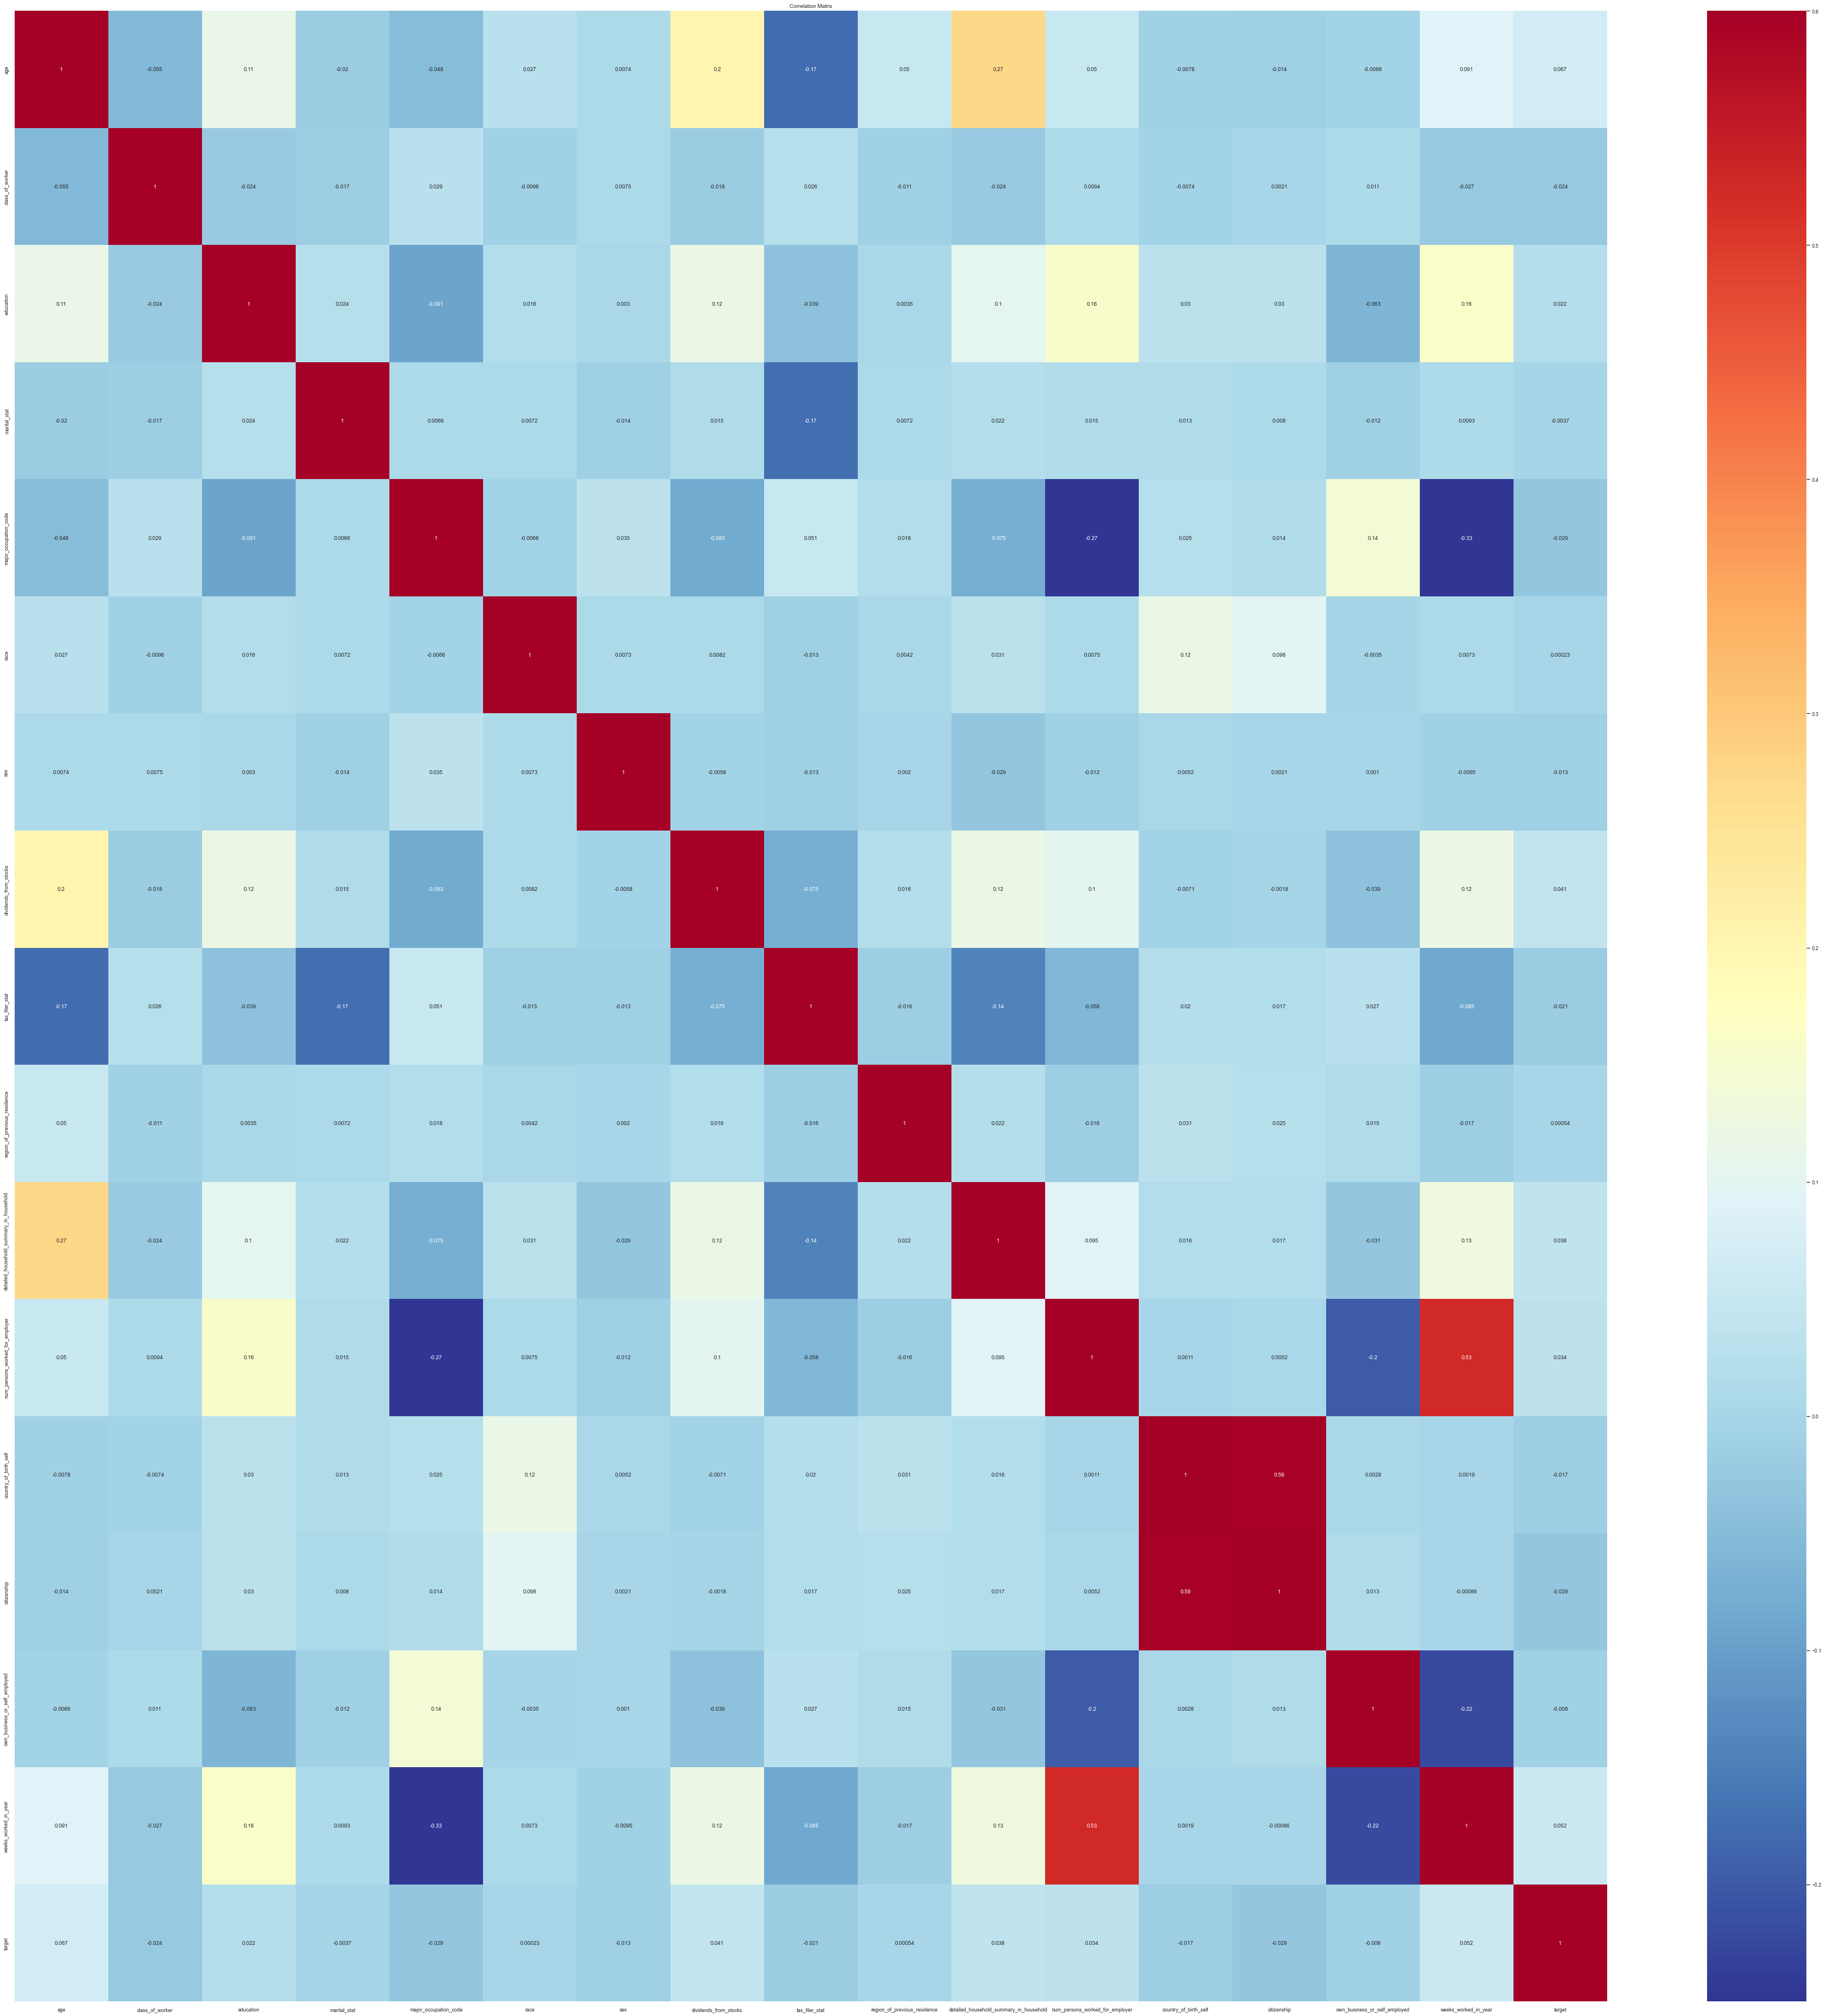

In [108]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [109]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.55:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [110]:
del_features

array(['country_of_birth_self'], dtype='<U21')

In [111]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [112]:
sorted(count_features)

['age',
 'citizenship',
 'class_of_worker',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [113]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [114]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [115]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [116]:
y_tr.isna().sum()

0

In [117]:
X_te2.isna().sum()

age                                          0
education                                    0
marital_stat                               264
race                                       182
sex                                         67
dividends_from_stocks                        1
tax_filer_stat                             264
region_of_previous_residence               143
detailed_household_summary_in_household    266
country_of_birth_self                      159
citizenship                                546
own_business_or_self_employed               10
weeks_worked_in_year                         0
dtype: int64

In [118]:
X_te_real1.isna().sum()

age                                          0
class_of_worker                              0
education                                    0
marital_stat                                 0
major_occupation_code                      120
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [119]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       93
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [120]:
sorted(synt_data['citizenship'].unique()) 


['- 40',
 '- 50000.',
 '- American Indian or Pacific Islander',
 '- Asian or Pacific Islander',
 '- International born abroad of American Parent present',
 '- Raracled User',
 '1',
 '10',
 '10th grade',
 '11th grade',
 '12+',
 '12-U S citizen by naturalization',
 '12-country_of_birth_self',
 '12th grade',
 '12th grade no diploma',
 '16',
 '17',
 '18 or older',
 '1B Bachelors degree(BA AB BS)',
 '1st 1st 2nd 3rd or 4th grade',
 '1st 2nd 3rd or 4th grade',
 '1st citizen of U S',
 '22 weeks_worked_in_year',
 '23',
 '24/73',
 '5th grade',
 '5th or 6th grade',
 '7',
 '7th and 8th grade',
 '9th grade',
 'Ab Foreign born- Not a citizen of U S',
 'Ab-Rocalvador',
 'Abdu-Averador',
 'Abig',
 'Abigail Filer',
 'Abill',
 'Abl war zone',
 'Abline MEdD B.',
 'Aborfed',
 'Abrigall but no degree',
 'Abroad',
 'Abroad & Outlying',
 'Abroad ( U S Bachelors degree(BA AB BS)',
 'Abroad born South Korea',
 'Abroad target',
 'Abroad+',
 'Abroad- Born in the United States',
 'Abroad- Not a citizen of U S',


In [121]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [122]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0

In [123]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 422 ms
Wall time: 412 ms


In [124]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.530 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.535 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.553 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.546 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.557 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.531 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.537 total time=   0.6s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.556 total time=   0.7s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.548 total time=   1.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.559 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.532 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.537 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.556 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.547 total time=   2.3s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.560 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.532 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.537 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.556 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.547 total time=   2.2s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.560 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.532 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.537 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.556 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.547 total time=   2.2s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.560 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.532 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.537 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.556 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.547 total time=   2.5s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.560 total time=   1.3s
CPU times: total: 52.9 s
Wall time: 53.2 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [125]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.5466429547010613
LogisticRegression(C=0.01, solver='saga')


In [126]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [127]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [128]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [129]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 297 ms
Wall time: 307 ms


In [130]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.535 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.534 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.543 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.546 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.540 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.538 total time=   0.9s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.542 total time=   0.8s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.551 total time=   0.9s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.552 total time=   1.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.543 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.539 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.541 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.553 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.552 total time=   2.3s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.543 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.539 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.542 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.553 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.552 total time=   2.4s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.543 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.539 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.542 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.553 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.552 total time=   2.5s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.543 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.539 total time=   3.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.542 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.553 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.552 total time=   3.1s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.543 total time=   1.3s
CPU times: total: 52.9 s
Wall time: 54.1 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [131]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.5458240566604589
LogisticRegression(C=1, solver='saga')


In [132]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [133]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [134]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [135]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.529418   

     Recall  Precision   ROC_AUC  
0  0.482385    0.06945  0.529418

In [136]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test           0.533278   

     Recall  Precision   ROC_AUC  
0  0.267196   0.082181  0.533278

## GPT2XL classification

### Data preprocessing 

In [137]:
synt_data = synt_data_gpt2xl.copy()

In [138]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [139]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [140]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [141]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [142]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Masters degree(MA MS MEng MEd MSW MBA)' '10th grade'
 'Associates degree-academic program' ... 'Associates degree-stat'
 'Prof school degree (MD DDS DVM LLBP JD)'
 'Associates degree-academic project'] 1135


In [143]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [144]:
to_encode_synt = to_encode.copy() 

In [145]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [146]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [147]:
print(X_tr.isna().sum())

age                                          0
class_of_worker                              0
education                                  884
marital_stat                                 0
major_occupation_code                        0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64


In [148]:
X_tr.fillna(0,inplace=True)

In [149]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [150]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.075305   0.219901   
class_of_worker                         -0.075305         1.000000  -0.060241   
education                                0.219901        -0.060241   1.000000   
marital_stat                             0.011319        -0.028617   0.051337   
major_occupation_code                   -0.096491        -0.026040  -0.171590   
race                                     0.092204        -0.005724   0.042056   
sex                                      0.012780         0.007755   0.003770   
dividends_from_stocks                    0.315892        -0.044141   0.282919   
tax_filer_stat                          -0.196745         0.029269  -0.066327   
region_of_previous_residence             0.103524        -0.031545   0.013398   
detailed_household_summary_in_household  0.359549        -0.041965   0.169097   
num_persons_worked_for_employer          0.091971         0.019004   0.250699   
country_of_birth_self                   -0.012807        -0.032649   0.015291   
citizenship                             -0.023166        -0.015716   0.010154   
own_business_or_self_employed           -0.007092        -0.001243  -0.140634   
weeks_worked_in_year                     0.137936        -0.006780   0.279860   
target                                   0.112567        -0.034849   0.144408   

                                         marital_stat  major_occupation_code  \
age                                          0.011319              -0.096491   
class_of_worker                             -0.028617              -0.026040   
education                                    0.051337              -0.171590   
marital_stat                                 1.000000              -0.008328   
major_occupation_code                       -0.008328               1.000000   
race                                         0.043802              -0.010738   
sex                                         -0.052103               0.079554   
dividends_from_stocks                        0.059678              -0.077165   
tax_filer_stat                              -0.316080               0.043846   
region_of_previous_residence                 0.030802               0.014129   
detailed_household_summary_in_household      0.070771              -0.117464   
num_persons_worked_for_employer              0.017029              -0.335129   
country_of_birth_self                        0.015141               0.036535   
citizenship                                  0.013048               0.037886   
own_business_or_self_employed               -0.007087               0.177205   
weeks_worked_in_year                         0.036021              -0.434117   
target                                       0.033907              -0.076689   

                                             race       sex  \
age                                      0.092204  0.012780   
class_of_worker                         -0.005724  0.007755   
education                                0.042056  0.003770   
marital_stat                             0.043802 -0.052103   
major_occupation_code                   -0.010738  0.079554   
race                                     1.000000 -0.012714   
sex                                     -0.012714  1.000000   
dividends_from_stocks                    0.092759 -0.012541   
tax_filer_stat                          -0.017425 -0.063555   
region_of_previous_residence             0.031539  0.006185   
detailed_household_summary_in_household  0.066846 -0.035166   
num_persons_worked_for_employer          0.014945 -0.022307   
country_of_birth_self                    0.133521 -0.011794   
citizenship                              0.101131 -0.007320   
own_business_or_self_employed           -0.022387  0.026554   
weeks_worked_in_year                     0.028485 -0.062031   
target                                   0.020382 -0.071238   

           

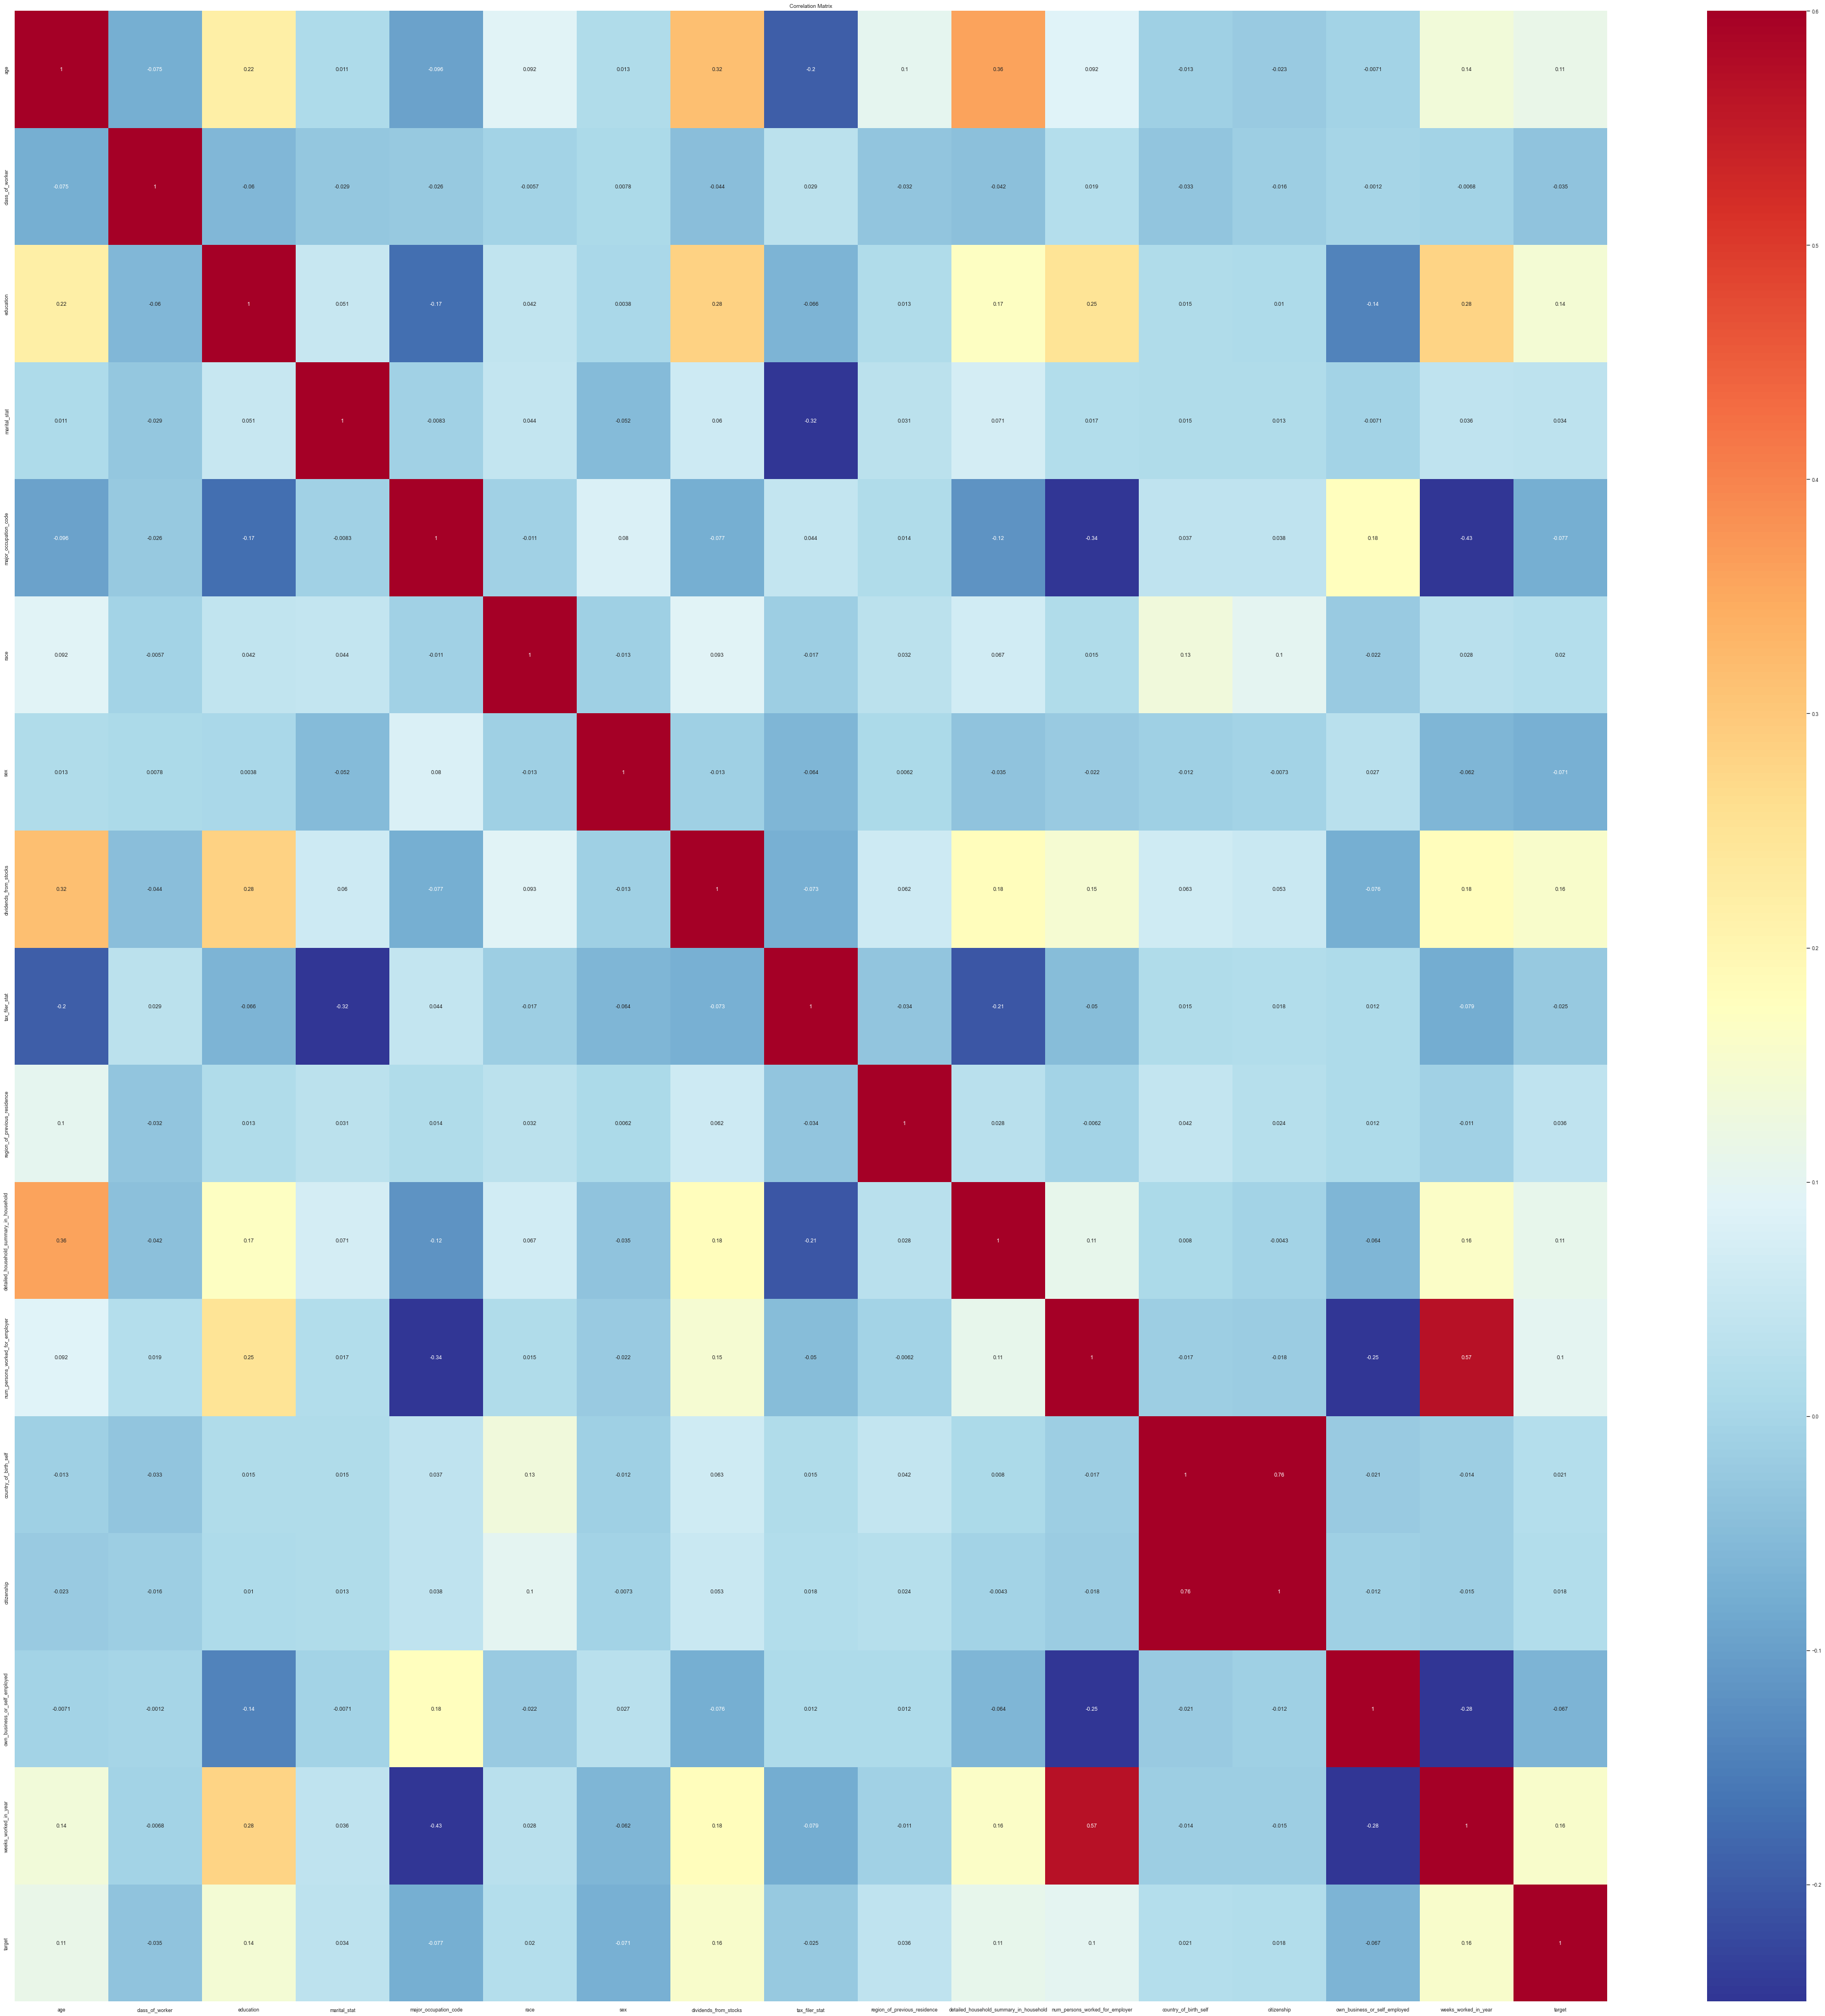

In [151]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [152]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [153]:
del_features

array(['citizenship'], dtype='<U11')

In [154]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [155]:
sorted(count_features)

['age',
 'class_of_worker',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [156]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [157]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [158]:
X_te2.isna().sum()

age                                          0
education                                  222
marital_stat                               142
race                                        88
sex                                         23
dividends_from_stocks                        0
tax_filer_stat                             111
region_of_previous_residence                83
detailed_household_summary_in_household    110
country_of_birth_self                       75
citizenship                                259
own_business_or_self_employed               18
weeks_worked_in_year                         0
dtype: int64

In [159]:
sorted(synt_data['country_of_birth_self'].unique()) 

['- 50000.',
 '0',
 'Abroad',
 'Ad-Rico',
 'Adm support including clerical',
 'Adrian',
 'Advantaicom',
 'Amer Indian Aleut or Eskimo',
 'American Samoa or Pacific Islander',
 'Armed Forces',
 'Asian',
 'Asian or Pacific Islander',
 'B',
 'B&N',
 'B.Toto',
 'BSR',
 'BTS-NU',
 'Bachelors degree(BA AB BS)',
 'Bafghanistan',
 'Baili orphan',
 'Bali',
 'Bander of household',
 'Bantu',
 'Bessacad&Tobago',
 'Black',
 'Black mediis 6',
 'Bologna',
 'Borne',
 'Bria',
 'Báthyrin Mexico',
 'Cambodia',
 "Cambodia's South Korea",
 'Canada',
 'Canada Canada',
 'Canada-U S (Guam USVI etc)',
 'Child 17 or older',
 'Child under 18 never married',
 'Children',
 'China',
 'China)',
 'Columbia',
 'Columbia_Republic',
 'Cuba',
 'Cuba and China',
 'Dominican - 50000.',
 'Dominican Adad&D in Puerto Rico or U S Outlying',
 'Dominican Aleut or Eskimo',
 'Dominican AmericanRepublic',
 'Dominican Columbia',
 'Dominican El-Salvador',
 'Dominican and Republic',
 'Dominican andRepublic',
 'Dominican in-Republic',


In [160]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [161]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [162]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 391 ms
Wall time: 434 ms


In [163]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.654 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.679 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.676 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.695 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.684 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.653 total time=   1.0s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.677 total time=   0.9s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.678 total time=   1.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.694 total time=   1.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.689 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.654 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.677 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.679 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.694 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.689 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.653 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.677 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.679 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.694 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.690 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.653 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.677 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.679 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.694 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.690 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.653 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.677 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.679 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.694 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.690 total time=   2.4s
CPU times: total: 59.9 s
Wall time: 1min 1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [164]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6786826128208233
LogisticRegression(C=0.01, solver='saga')


In [165]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [166]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [167]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test            0.65805   

     Recall  Precision  ROC_AUC  
0  0.685185   0.110968  0.65805

In [168]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.784389   

     Recall  Precision   ROC_AUC  
0  0.944444   0.144593  0.784389

In [169]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 359 ms
Wall time: 353 ms


In [170]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.644 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.657 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.664 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.680 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.671 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.645 total time=   1.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.658 total time=   1.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.663 total time=   1.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.681 total time=   0.8s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.675 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.649 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.661 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.666 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.682 total time=   2.3s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.675 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.650 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.664 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.667 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.683 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.677 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.651 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.664 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.667 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.683 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.678 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.651 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.664 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.667 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.683 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.678 total time=   2.2s
CPU times: total: 55.8 s
Wall time: 57.3 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [171]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6684058598166507
LogisticRegression(C=10, solver='saga')


In [172]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [173]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [174]:
res_test22

Model     Dataset  Balanced_accuracy   Recall  \
0  LogRegression GPT2xl real features  Synth test           0.659751  0.68254   

   Precision   ROC_AUC  
0   0.112223  0.659751

In [175]:
res_test_real22

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression GPT2xl real features  Real test           0.766935  0.949735   

   Precision   ROC_AUC  
0   0.133111  0.766935

## Cerebras classification

### Data preprocessing 

In [176]:
synt_data = synt_data_cerebras.copy()

In [177]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [178]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [179]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [180]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [181]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['High school graduate' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Some college but no degree' '9th grade' '1st 2nd 3rd or 4th grade'
 'Bachelors degree(BA AB BS)' 'White' 'Children'
 'Technicians and related support' 'Associates degree-occup /vocational'
 'Less than 1st grade' 'Associates degree-academic program'
 'Other service' 'Doctorate degree(PhD EdD)'
 'Prof school degree (MD DDS DVM LLB JD)' '11th grade'
 'Professorship degree (MD DDS DVM LLB JD)' '5th or 6th grade'
 'Associates degree- 5th or 6th grade'
 'Associates degree- weeks_worked_in_year' '6th or 7th grade'
 '7th and 8th grade' '10th grade' '2nd 3rd or 4th grade'
 'Doctorate degree(C program)' '12th grade no diploma' 'Householder'
 '15th or 8th grade' '- Prof school degree (MD DDS DVM LLB JD)' 'Single'
 'Associates degree-filer_stat' '5th or 4th grade'
 'Masters degree(MA DDS DVM LLB JD)' '13th and 8th grade'
 '1st 2nd 4th or 6th grade' 'Precision production craft & repair'
 'Adm support including clerical' 'Married-civ

In [182]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [183]:
to_encode_synt = to_encode.copy() 

In [184]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [185]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [186]:
print(X_tr.isna().sum())

age                                          0
class_of_worker                              0
education                                  647
marital_stat                                 0
major_occupation_code                        0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64


In [187]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [188]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.072241   0.265439   
class_of_worker                         -0.072241         1.000000  -0.070912   
education                                0.265439        -0.070912   1.000000   
marital_stat                             0.026528        -0.026476   0.061173   
major_occupation_code                   -0.092677        -0.052673  -0.176608   
race                                     0.075663        -0.005764   0.059648   
sex                                      0.010194         0.018875   0.008009   
dividends_from_stocks                    0.319804        -0.061984   0.323813   
tax_filer_stat                          -0.187564         0.027711  -0.081834   
region_of_previous_residence             0.103592        -0.017057   0.011796   
detailed_household_summary_in_household  0.363377        -0.033498   0.198269   
num_persons_worked_for_employer          0.109332         0.032395   0.291990   
country_of_birth_self                   -0.025724        -0.032355   0.025312   
citizenship                             -0.029695        -0.021910   0.017801   
own_business_or_self_employed           -0.024942        -0.006803  -0.166481   
weeks_worked_in_year                     0.151050         0.002683   0.320396   
target                                   0.122406        -0.025927   0.154392   

                                         marital_stat  major_occupation_code  \
age                                          0.026528              -0.092677   
class_of_worker                             -0.026476              -0.052673   
education                                    0.061173              -0.176608   
marital_stat                                 1.000000              -0.014678   
major_occupation_code                       -0.014678               1.000000   
race                                         0.037330              -0.006531   
sex                                         -0.060721               0.092689   
dividends_from_stocks                        0.067779              -0.080045   
tax_filer_stat                              -0.329711               0.037286   
region_of_previous_residence                 0.049316               0.011471   
detailed_household_summary_in_household      0.085935              -0.119345   
num_persons_worked_for_employer              0.023414              -0.348321   
country_of_birth_self                        0.017448               0.055074   
citizenship                                  0.018156               0.053881   
own_business_or_self_employed               -0.023268               0.175665   
weeks_worked_in_year                         0.043011              -0.441559   
target                                       0.040314              -0.067200   

                                             race       sex  \
age                                      0.075663  0.010194   
class_of_worker                         -0.005764  0.018875   
education                                0.059648  0.008009   
marital_stat                             0.037330 -0.060721   
major_occupation_code                   -0.006531  0.092689   
race                                     1.000000 -0.002243   
sex                                     -0.002243  1.000000   
dividends_from_stocks                    0.093425 -0.002653   
tax_filer_stat                          -0.013930 -0.056383   
region_of_previous_residence             0.039992  0.000950   
detailed_household_summary_in_household  0.057197 -0.035681   
num_persons_worked_for_employer          0.013529 -0.014151   
country_of_birth_self                    0.143093 -0.004043   
citizenship                              0.122107 -0.002700   
own_business_or_self_employed           -0.030833  0.021266   
weeks_worked_in_year                     0.028580 -0.062798   
target                                   0.020148 -0.068022   

           

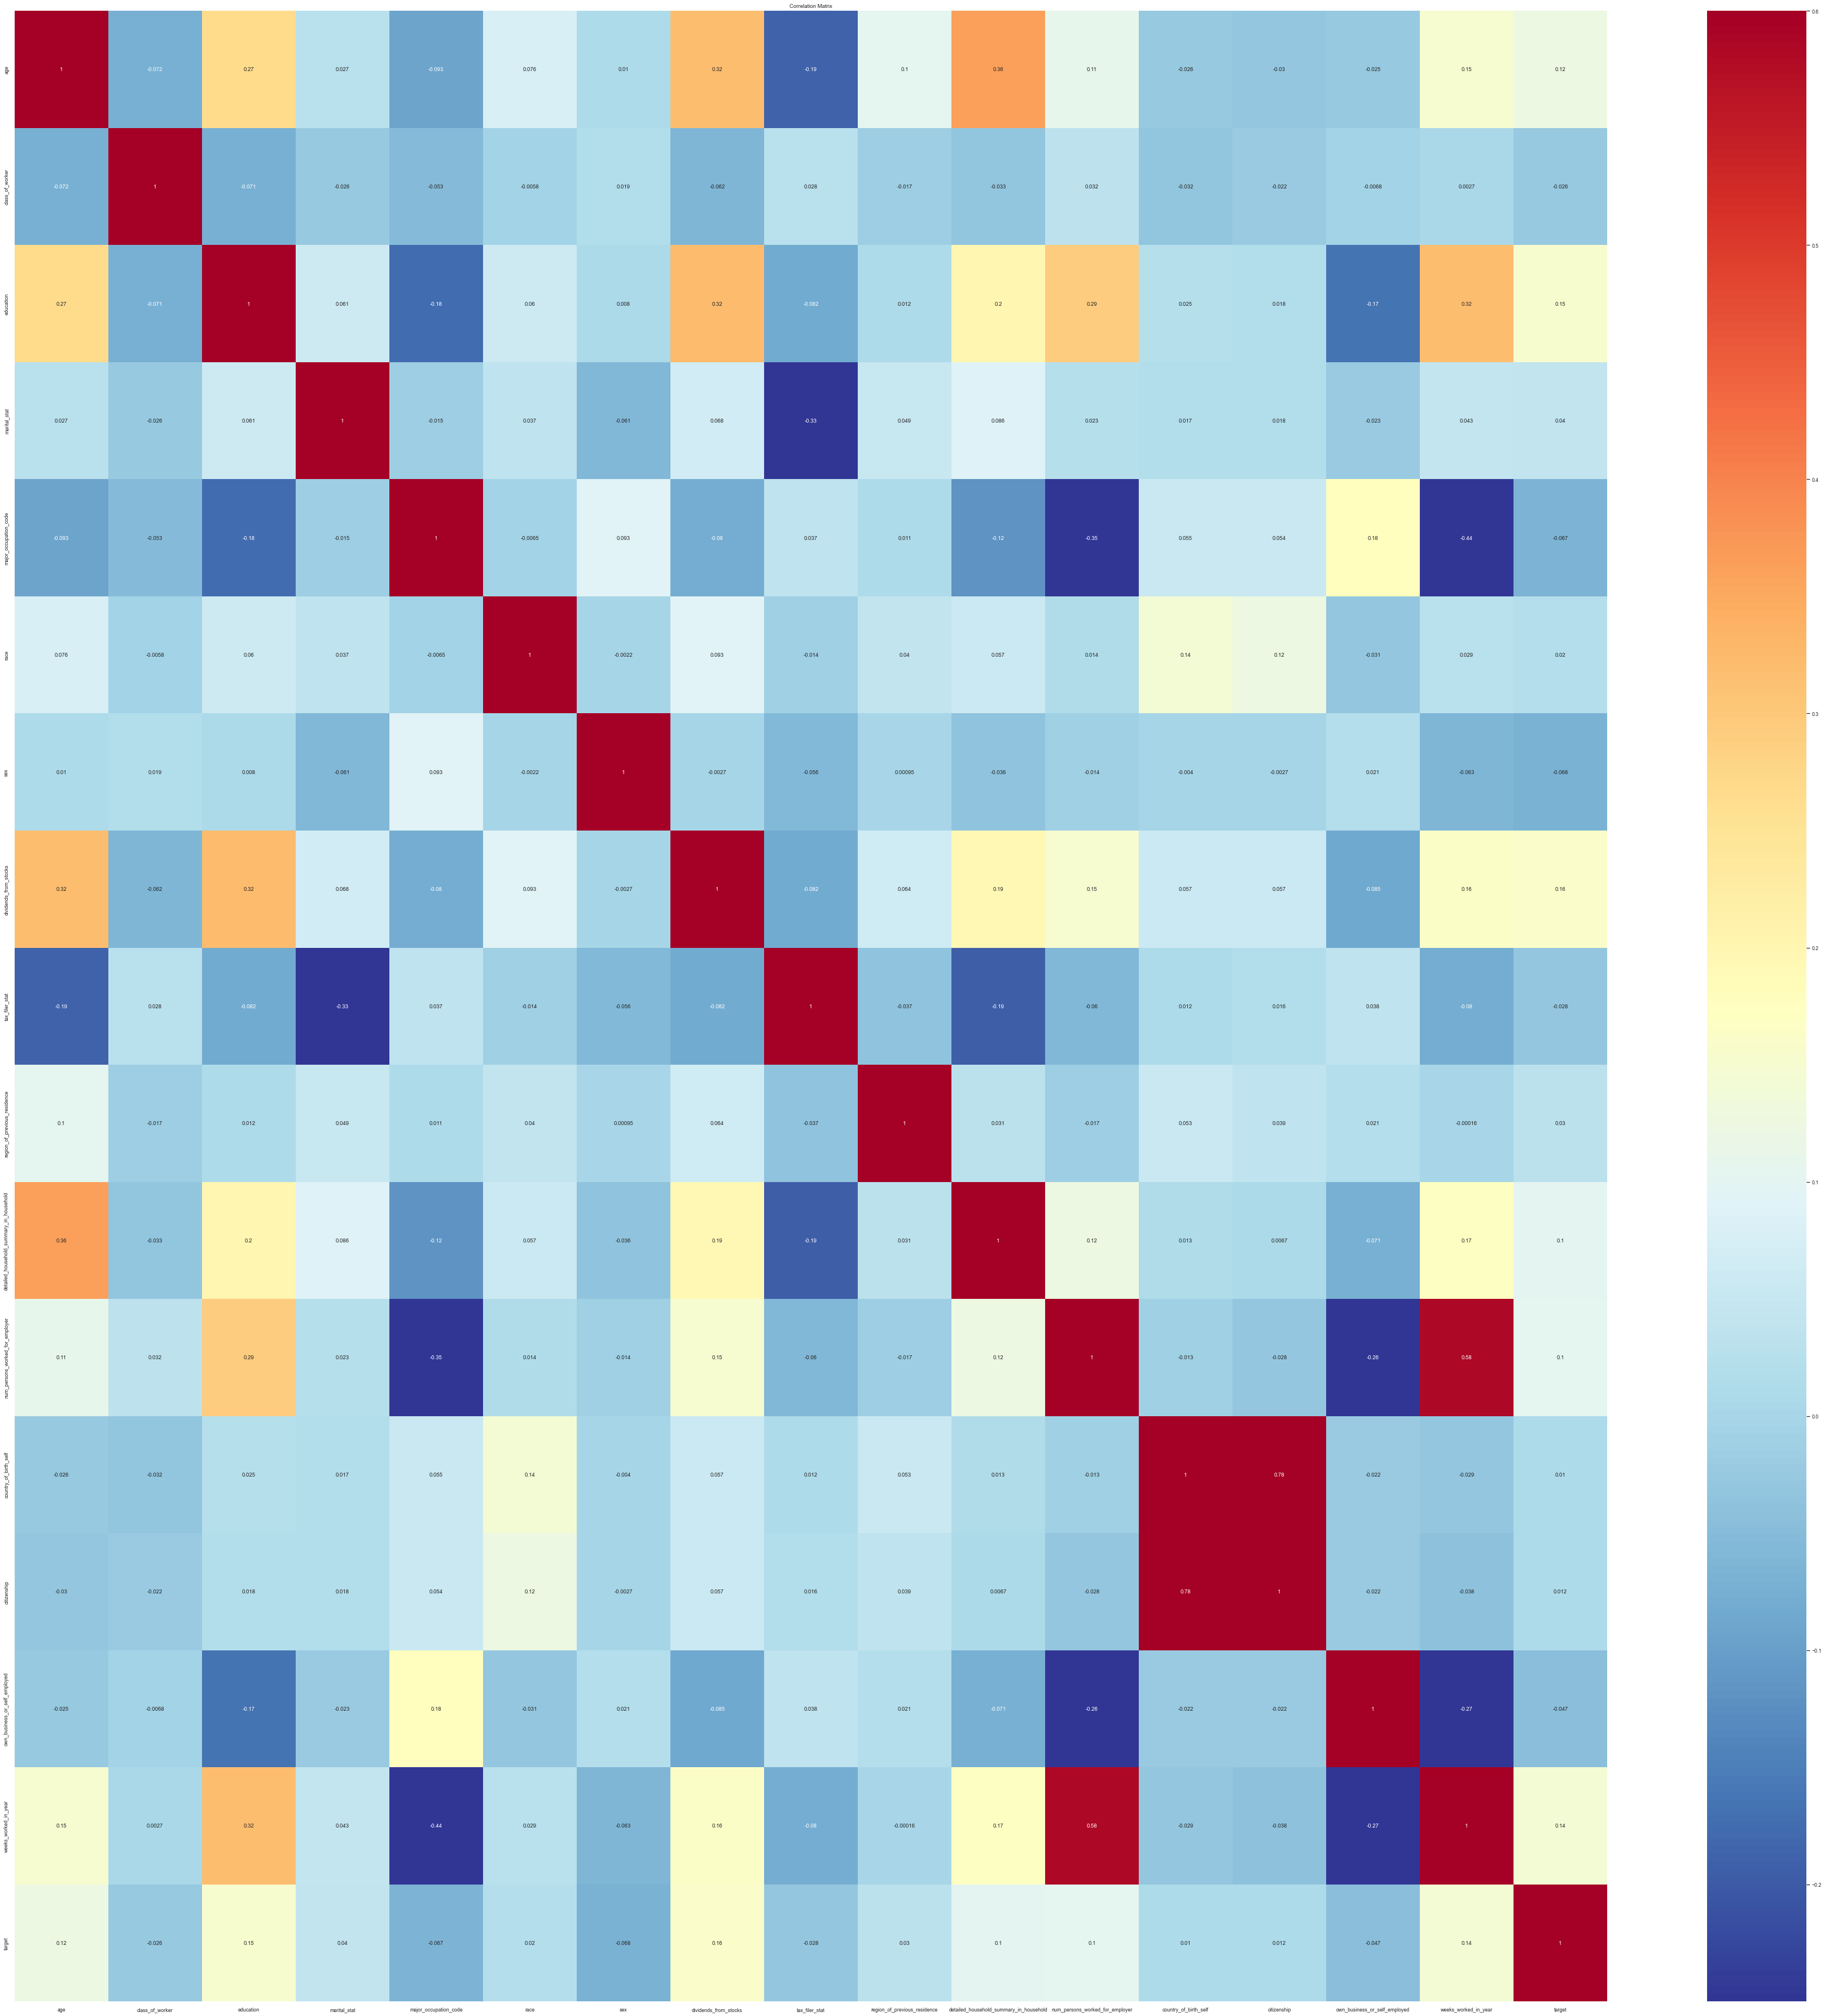

In [189]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [190]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [191]:
del_features

array(['country_of_birth_self'], dtype='<U21')

In [192]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [193]:
sorted(count_features)

['age',
 'citizenship',
 'class_of_worker',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [194]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [195]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [196]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       93
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [197]:
sorted(synt_data['citizenship'].unique()) 

['0',
 '1',
 '1-civilian spouse present',
 '10- Born in the United States',
 '11 Native- Born in the United States',
 '11th grade',
 '12 Native- Born in the United States',
 '18 but no place',
 '1st 2nd 3rd or 4th grade',
 '1st2 and 3rd',
 '5',
 '50000+.',
 '592',
 '5th or 6th grade',
 '7th and 8th grade',
 '84',
 '9- Native- Born abroad of American Parent(s)',
 '9is Foreign born- Not a citizen of U S',
 'Abroad',
 'Adm support including clerarchy',
 'Adm support including clerical',
 'Adm support such as clerical',
 'Adri or Pacific Islander',
 'Amer Indian Aleut or Eskimo',
 'Armed Forces',
 'Asian or Pacific Islander',
 'Asian or Pacific Islanderi',
 'Asian_ Pacific Islander',
 'Associates degree- Prof school degree (MD DDS DVM LLB JD)',
 'Associates degree-academic program',
 'Associates degree-not incorporated',
 'Associates degree-occup /vocational',
 'Bachelors degree(BA AB BS)',
 'Black',
 'Black.',
 'Born abroad of American Parent(s)',
 'Canada',
 'Child',
 'Child 18 or older'

In [198]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [199]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [200]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 359 ms
Wall time: 418 ms


In [201]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.659 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.667 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.658 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.665 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.656 total time=   0.4s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.665 total time=   0.9s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.670 total time=   0.7s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.661 total time=   0.6s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.663 total time=   0.5s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.663 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.665 total time=   2.5s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.672 total time=   2.3s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.662 total time=   2.0s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.661 total time=   2.0s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.664 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.665 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.672 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.661 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.661 total time=   2.5s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.664 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.665 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.672 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.661 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.661 total time=   2.5s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.664 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.665 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.672 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.661 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.661 total time=   2.2s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.664 total time=   2.1s
CPU times: total: 51.8 s
Wall time: 53.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [202]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6648541732883595
LogisticRegression(C=0.01, solver='saga')


In [203]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [204]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [205]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test           0.649618   

     Recall  Precision   ROC_AUC  
0  0.683784   0.104632  0.649618

In [206]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.782254   

     Recall  Precision   ROC_AUC  
0  0.944444   0.143201  0.782254

In [207]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 312 ms
Wall time: 307 ms


In [208]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.662 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.654 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.657 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.657 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.654 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.665 total time=   0.7s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.652 total time=   0.6s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.657 total time=   0.8s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.660 total time=   0.6s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.659 total time=   0.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.665 total time=   2.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.653 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.657 total time=   2.7s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.660 total time=   1.5s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.659 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.667 total time=   2.2s
[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.653 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.657 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.661 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.660 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.667 total time=   2.0s
[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.653 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.657 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.661 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.660 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.667 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.653 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.657 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.661 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.660 total time=   2.1s
CPU times: total: 49.5 s
Wall time: 52 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [209]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6595783039990434
LogisticRegression(C=1, solver='saga')


In [210]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [211]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [212]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.641935   

     Recall  Precision   ROC_AUC  
0  0.664865   0.102886  0.641935

In [213]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.767302   

    Recall  Precision   ROC_AUC  
0  0.94709   0.133732  0.767302

## Phi1.5 classification

### Data preprocessing 

In [214]:
synt_data = synt_data_phi.copy()

In [215]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [216]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [217]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [218]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [219]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['5th or 6th grade' 'High school graduate' 'Abachelors degree(BA AB BS)'
 '1st 2nd 3rd or 4th grade' 'Asian or Pacific Islander'
 'Bachelors degree(BA AB BS)' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Prof school degree (MD DDS DVM LLB JD)' 'Children'
 '12th grade no diploma' '10th grade' 'Some college but no degree'
 'Less than 1st grade' '7th and 8th grade' '11th grade' '9th grade'
 'Associates degree-academic program' '7th and 4th grade'
 'Associates degree-occup /vocational' 'Doctorate degree(PhD EdD)' 'White'
 '- 50000.' 'Some' 'Some college graduate' '1st 2 6th or third grade'
 'Not in universe' 'Nonrelative of householder' '16th grade' '6th grade'
 '13th grade' '15th grade' 'Associates degree- Not in universe'
 'Never married' 'Joint both under 65' 'Professional degree(BA AB BS)'
 '18th grade' 'Self-employed-incorporated' 'Associates program'
 '1st 2nd 3rd or Eskimo' '0' '17th grade' 'U S (MD DDS DVM LLB JD)'
 '2nd school degree (MD DDS DVM LLB JD)' 'Less than onest grade'
 '7t

In [220]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [221]:
to_encode_synt = to_encode.copy() 

In [222]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [223]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [224]:
print(X_tr.isna().sum())

age                                          0
class_of_worker                              0
education                                  443
marital_stat                                 0
major_occupation_code                        0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64


In [225]:
#X_tr.fillna(0,inplace=True)

In [226]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [227]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.079211   0.256793   
class_of_worker                         -0.079211         1.000000  -0.072105   
education                                0.256793        -0.072105   1.000000   
marital_stat                             0.024842        -0.026796   0.046698   
major_occupation_code                   -0.077832        -0.062318  -0.168928   
race                                     0.075153        -0.012360   0.036908   
sex                                      0.020099         0.013547   0.004695   
dividends_from_stocks                    0.314508        -0.069755   0.335743   
tax_filer_stat                          -0.199662         0.026443  -0.080119   
region_of_previous_residence             0.106107        -0.022429   0.005139   
detailed_household_summary_in_household  0.370490        -0.025775   0.201564   
num_persons_worked_for_employer          0.097076         0.042691   0.287792   
country_of_birth_self                   -0.038180        -0.041541   0.032015   
citizenship                             -0.036338        -0.032341   0.028390   
own_business_or_self_employed           -0.008059        -0.003484  -0.167461   
weeks_worked_in_year                     0.141086         0.002178   0.314256   
target                                   0.109794        -0.030340   0.126109   

                                         marital_stat  major_occupation_code  \
age                                          0.024842              -0.077832   
class_of_worker                             -0.026796              -0.062318   
education                                    0.046698              -0.168928   
marital_stat                                 1.000000              -0.016178   
major_occupation_code                       -0.016178               1.000000   
race                                         0.045534              -0.003041   
sex                                         -0.046254               0.086680   
dividends_from_stocks                        0.072943              -0.063091   
tax_filer_stat                              -0.336842               0.041203   
region_of_previous_residence                 0.039807               0.021551   
detailed_household_summary_in_household      0.097349              -0.109919   
num_persons_worked_for_employer              0.016405              -0.341911   
country_of_birth_self                        0.006872               0.023523   
citizenship                                  0.012722               0.031954   
own_business_or_self_employed               -0.013691               0.192442   
weeks_worked_in_year                         0.031498              -0.431996   
target                                       0.031075              -0.050198   

                                             race       sex  \
age                                      0.075153  0.020099   
class_of_worker                         -0.012360  0.013547   
education                                0.036908  0.004695   
marital_stat                             0.045534 -0.046254   
major_occupation_code                   -0.003041  0.086680   
race                                     1.000000 -0.002837   
sex                                     -0.002837  1.000000   
dividends_from_stocks                    0.088979  0.008733   
tax_filer_stat                          -0.026607 -0.047535   
region_of_previous_residence             0.042151  0.007983   
detailed_household_summary_in_household  0.044652 -0.025201   
num_persons_worked_for_employer          0.000262 -0.011248   
country_of_birth_self                    0.135286 -0.007031   
citizenship                              0.107384 -0.007034   
own_business_or_self_employed           -0.012754  0.016007   
weeks_worked_in_year                     0.022933 -0.047121   
target                                   0.023408 -0.067656   

           

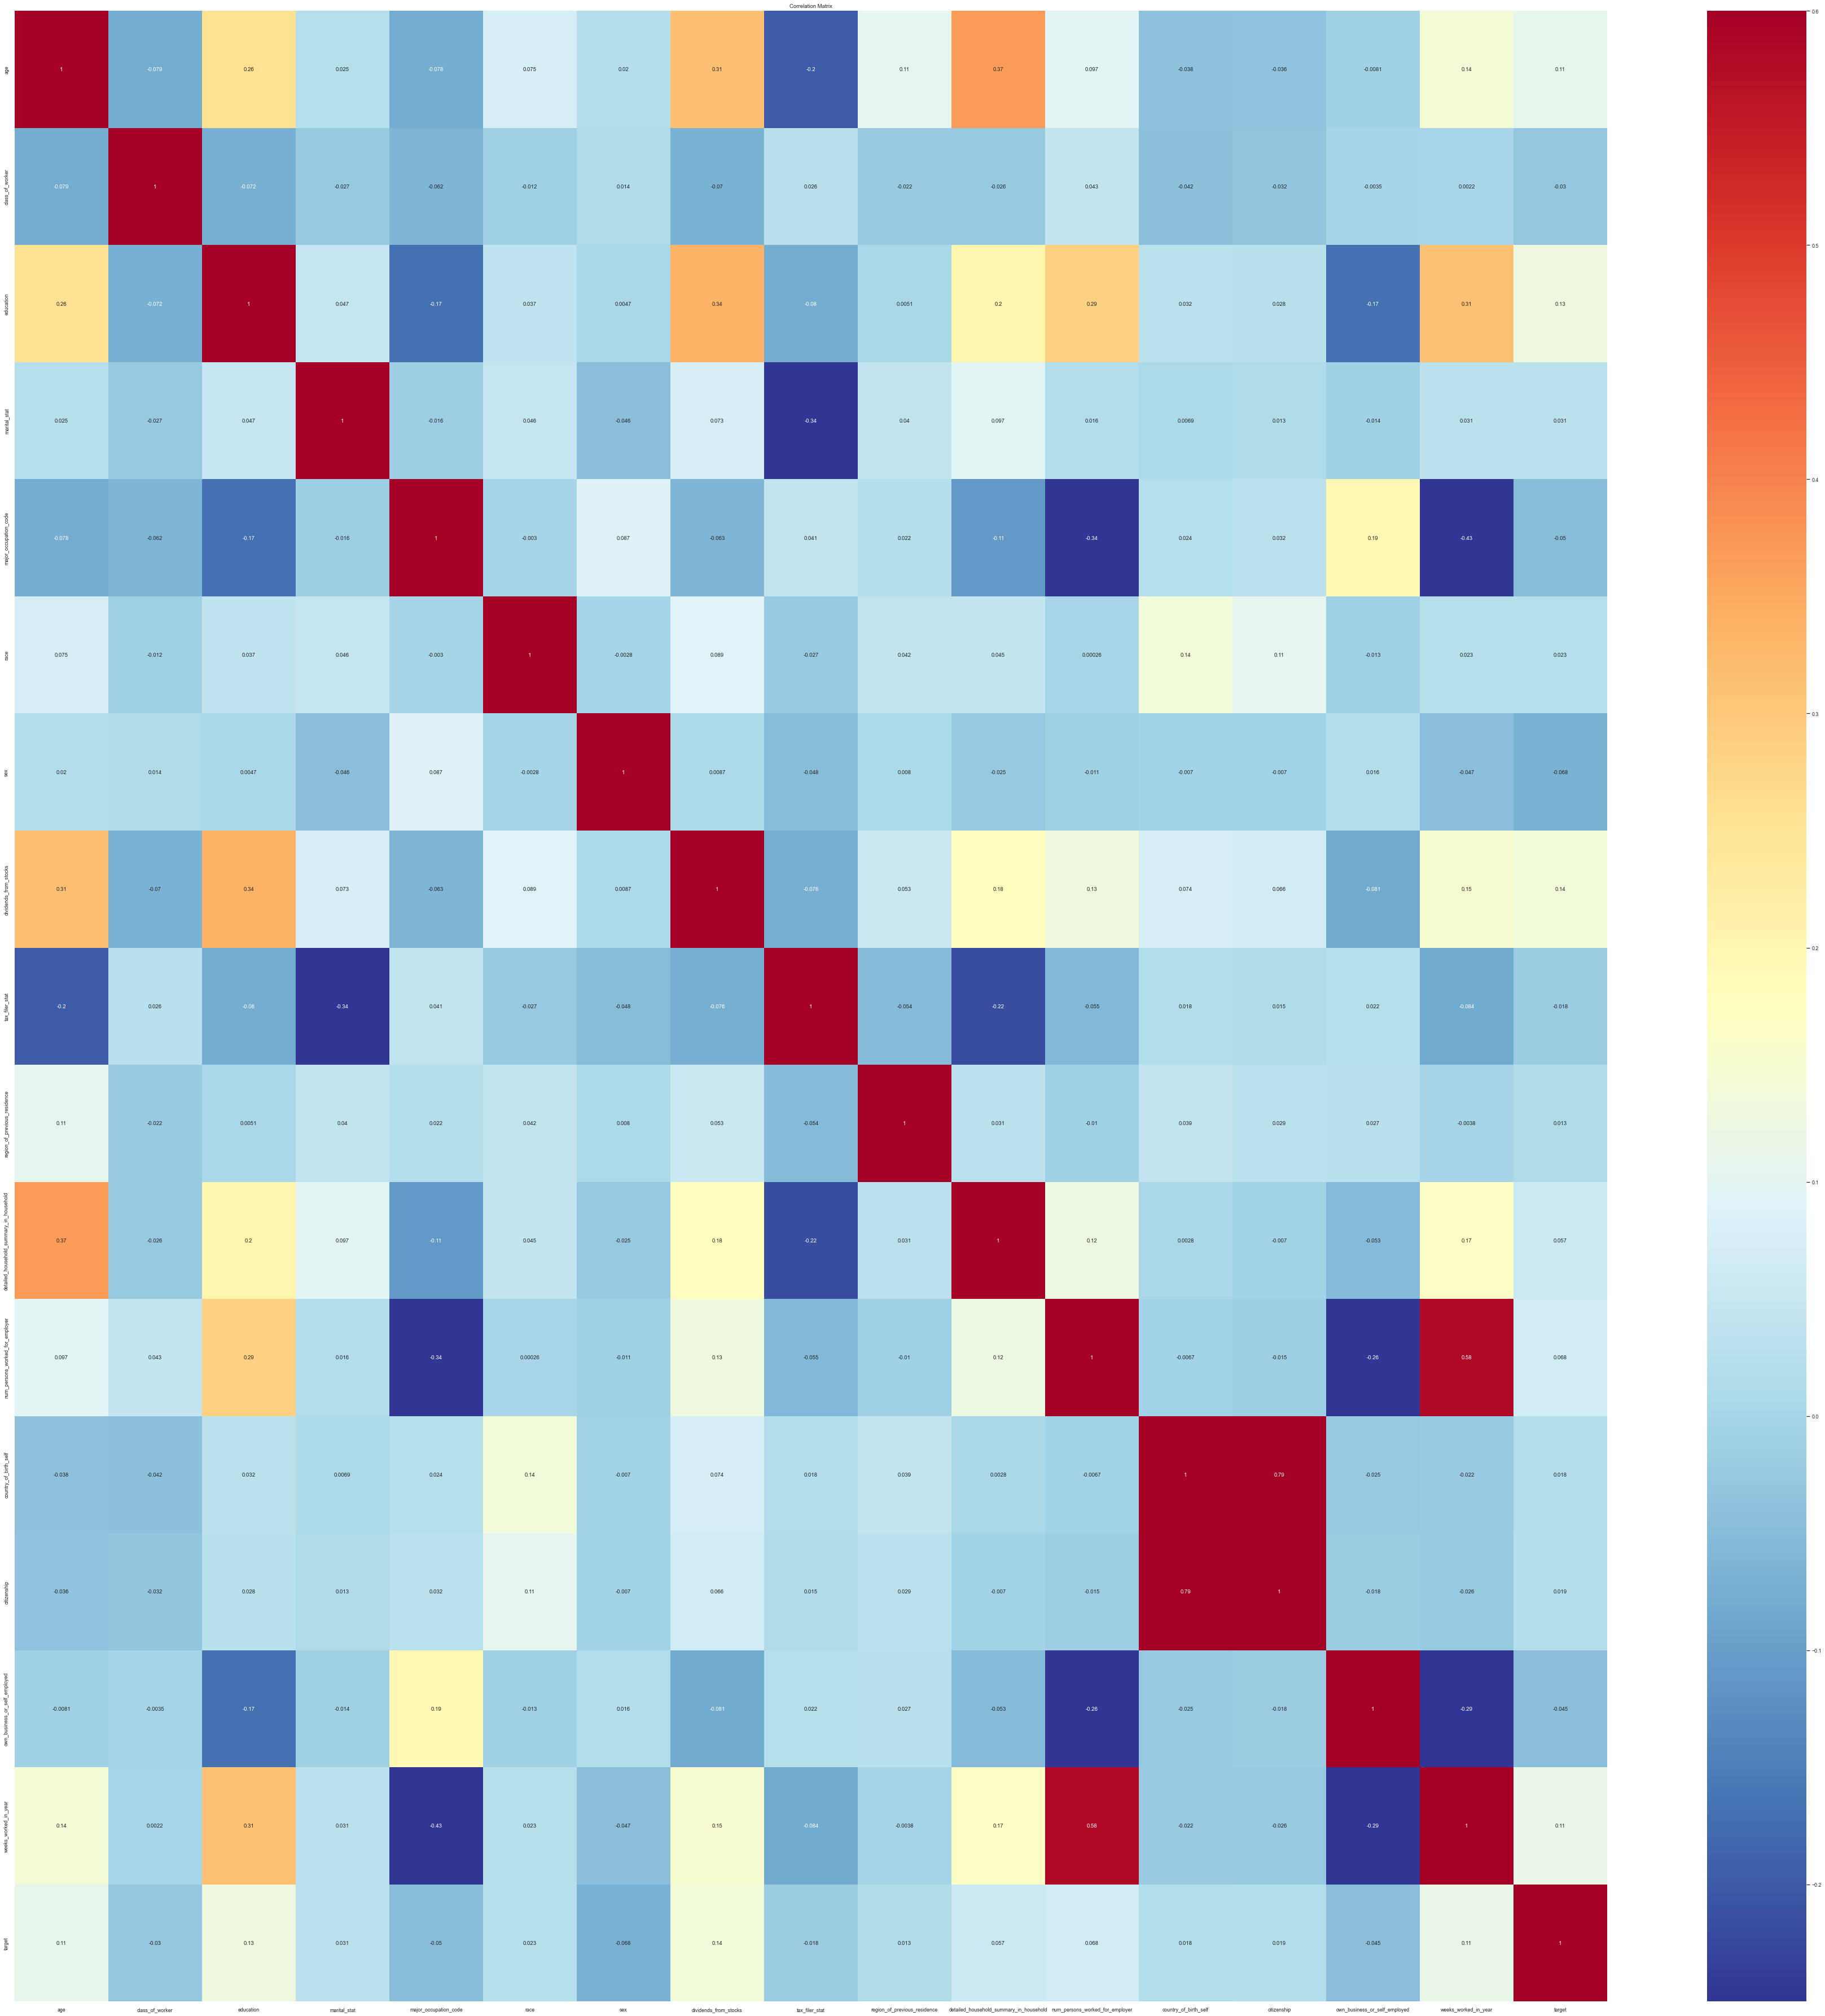

In [228]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [229]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [230]:
del_features

array(['country_of_birth_self'], dtype='<U21')

In [231]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [232]:
sorted(count_features)

['age',
 'citizenship',
 'class_of_worker',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [233]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [234]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [235]:
X_te2.isna().sum()

age                                          0
education                                  114
marital_stat                                62
race                                        46
sex                                         25
dividends_from_stocks                        0
tax_filer_stat                              68
region_of_previous_residence                63
detailed_household_summary_in_household     57
country_of_birth_self                       74
citizenship                                102
own_business_or_self_employed                7
weeks_worked_in_year                         0
dtype: int64

In [236]:
sorted(synt_data['country_of_birth_self'].unique()) 

['- 50000.',
 '0',
 'Abroad',
 'Ad Haiti',
 'Ad Jamaica',
 'Ad Japan',
 'Adad&D)',
 'Adad&Rico',
 'Adad&adad &Tobago',
 'Adadspouse of householder',
 'Adm support including clerical',
 'Amer Indian Aleut or Eskimo',
 'Asian Thailand',
 'Asian or Pacific Islander',
 'Bachelors degree(BA AB BS)',
 'Black',
 'Black.',
 'Cambodia',
 'Cambodia Cambodia',
 'Cambodia Kong',
 'Cambodia)',
 'Canada',
 'Canada 9',
 'Canada Canada',
 'Canada Columbia',
 'Canada France',
 'Canada Portugal',
 'Canada South Korea',
 'Canada government',
 'Canada one',
 'Canada target',
 'Canada under 65 0',
 'Canada- Germany',
 'Canada.',
 'Child 18 or older',
 'Child under 18 never married',
 'Children',
 'China',
 'China (China)',
 'China - 50000.',
 'China Hong Kong',
 'China Taiwan',
 'China etc',
 'China of India',
 'China or Vietnam',
 'China)',
 'China-Rico',
 'China-Taiimo',
 'China.',
 'Chinaadad&N S',
 'Chinaadad&Tobago',
 'Chinaer',
 'Columbia',
 'Columbia abroad',
 'Columbia inForeign born- Not a citizen

In [237]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [238]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [239]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 344 ms
Wall time: 370 ms


In [240]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.622 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.640 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.604 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.630 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.638 total time=   0.4s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.627 total time=   2.0s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.644 total time=   1.6s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.610 total time=   2.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.633 total time=   1.6s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.639 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.629 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.645 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.611 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.637 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.643 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.630 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.646 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.611 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.636 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.644 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.631 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.647 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.611 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.636 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.644 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.631 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.646 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.611 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.636 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.644 total time=   2.7s
CPU times: total: 59.7 s
Wall time: 1min 2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [241]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6335849198649717
LogisticRegression(C=10, solver='saga')


In [242]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [243]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [244]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test           0.624089   

     Recall  Precision   ROC_AUC  
0  0.661333   0.096423  0.624089

In [245]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test           0.774249   

     Recall  Precision   ROC_AUC  
0  0.965608   0.134686  0.774249

In [246]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 297 ms
Wall time: 301 ms


In [247]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.627 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.641 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.610 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.625 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.628 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.626 total time=   1.7s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.643 total time=   1.6s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.617 total time=   1.7s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.629 total time=   1.5s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.634 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.632 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.648 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.612 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.634 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.640 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.634 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.648 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.612 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.634 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.641 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.634 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.648 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.612 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.635 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.642 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.634 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.648 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.612 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.635 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.642 total time=   2.3s
CPU times: total: 50.6 s
Wall time: 53.1 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [248]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.634173509408537
LogisticRegression(C=10, solver='saga')


In [249]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [250]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [251]:
res_test42

Model     Dataset  Balanced_accuracy  Recall  \
0  LogRegression Phi1.5 real features  Synth test           0.631467    0.68   

   Precision   ROC_AUC  
0   0.098039  0.631467

In [252]:
res_test_real42

Model    Dataset  Balanced_accuracy   Recall  \
0  LogRegression Phi1.5 real features  Real test           0.760063  0.97619   

   Precision   ROC_AUC  
0    0.12581  0.760063

## Modelling result

In [253]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.545639   
0  LogRegression DistillGPT synthetic features   Real test           0.581058   
0       LogRegression DistillGPT real features  Synth test           0.529418   
0       LogRegression DistillGPT real features   Real test           0.533278   
0      LogRegression GPT2xl synthetic features  Synth test           0.658050   
0      LogRegression GPT2xl synthetic features   Real test           0.784389   
0           LogRegression GPT2xl real features  Synth test           0.659751   
0           LogRegression GPT2xl real features   Real test           0.766935   
0    LogRegression Cerebras synthetic features  Synth test           0.649618   
0    LogRegression Cerebras synthetic features   Real test           0.782254   
0         LogRegression Cerebras real features  Synth test           0.641935   
0         LogRegression Cerebras real features   Real test           0.767302   
0      LogRegression Phi1.5 synthetic features  Synth test           0.624089   
0      LogRegression Phi1.5 synthetic features   Real test           0.774249   
0           LogRegression Phi1.5 real features  Synth test           0.631467   
0           LogRegression Phi1.5 real features   Real test           0.760063   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.531165   0.073326  0.545639  
0  0.283069   0.135959  0.581058  
0  0.482385   0.069450  0.529418  
0  0.267196   0.082181  0.533278  
0  0.685185   0.110968  0.658050  
0  0.944444   0.144593  0.784389  
0  0.682540   0.112223  0.659751  
0  0.949735   0.133111  0.766935  
0  0.683784   0.104632  0.649618  
0  0.944444   0.143201  0.782254  
0  0.664865   0.102886  0.641935  
0  0.947090   0.133732  0.767302  
0  0.661333   0.096423  0.624089  
0  0.965608   0.134686  0.774249  
0  0.680000   0.098039  0.631467  
0  0.976190   0.125810  0.760063

In [254]:
model_results.to_csv('model_results_shortincome_temp1.9.csv')

# Privacy metrics

In [255]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [256]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

In [257]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [258]:
tgt_train = real_dataset.copy()

In [259]:
tgt_test = control_dataset.copy()

In [260]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [261]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [262]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [263]:
hmm_train = map_humming(hmm_train,hmm)

In [264]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [265]:
norm_weights

[90, 99999, 6, 52]

In [266]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [267]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [268]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [269]:
hmm_test = map_humming(hmm_test,hmm)

In [270]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [271]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

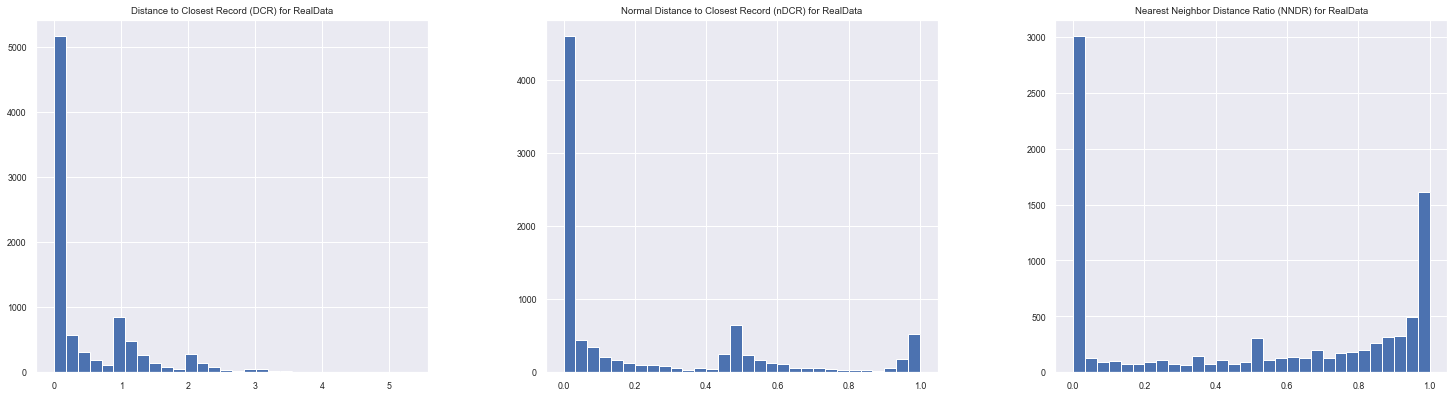

In [272]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [273]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [274]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [275]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [276]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [277]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_10360\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [278]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [279]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [280]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [281]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [282]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats nan nan nan nan 9000
nDCR stats 0.9558460695846498 0.15774687809177593 1.0 0.0 9000
DCR Bound 0.95 % = 8.03339958014965


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

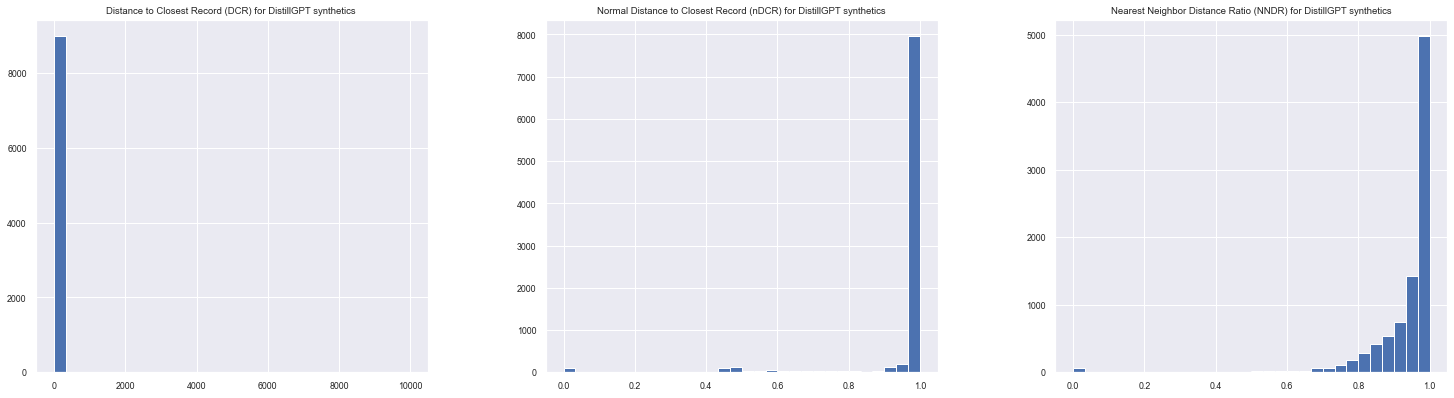

In [283]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

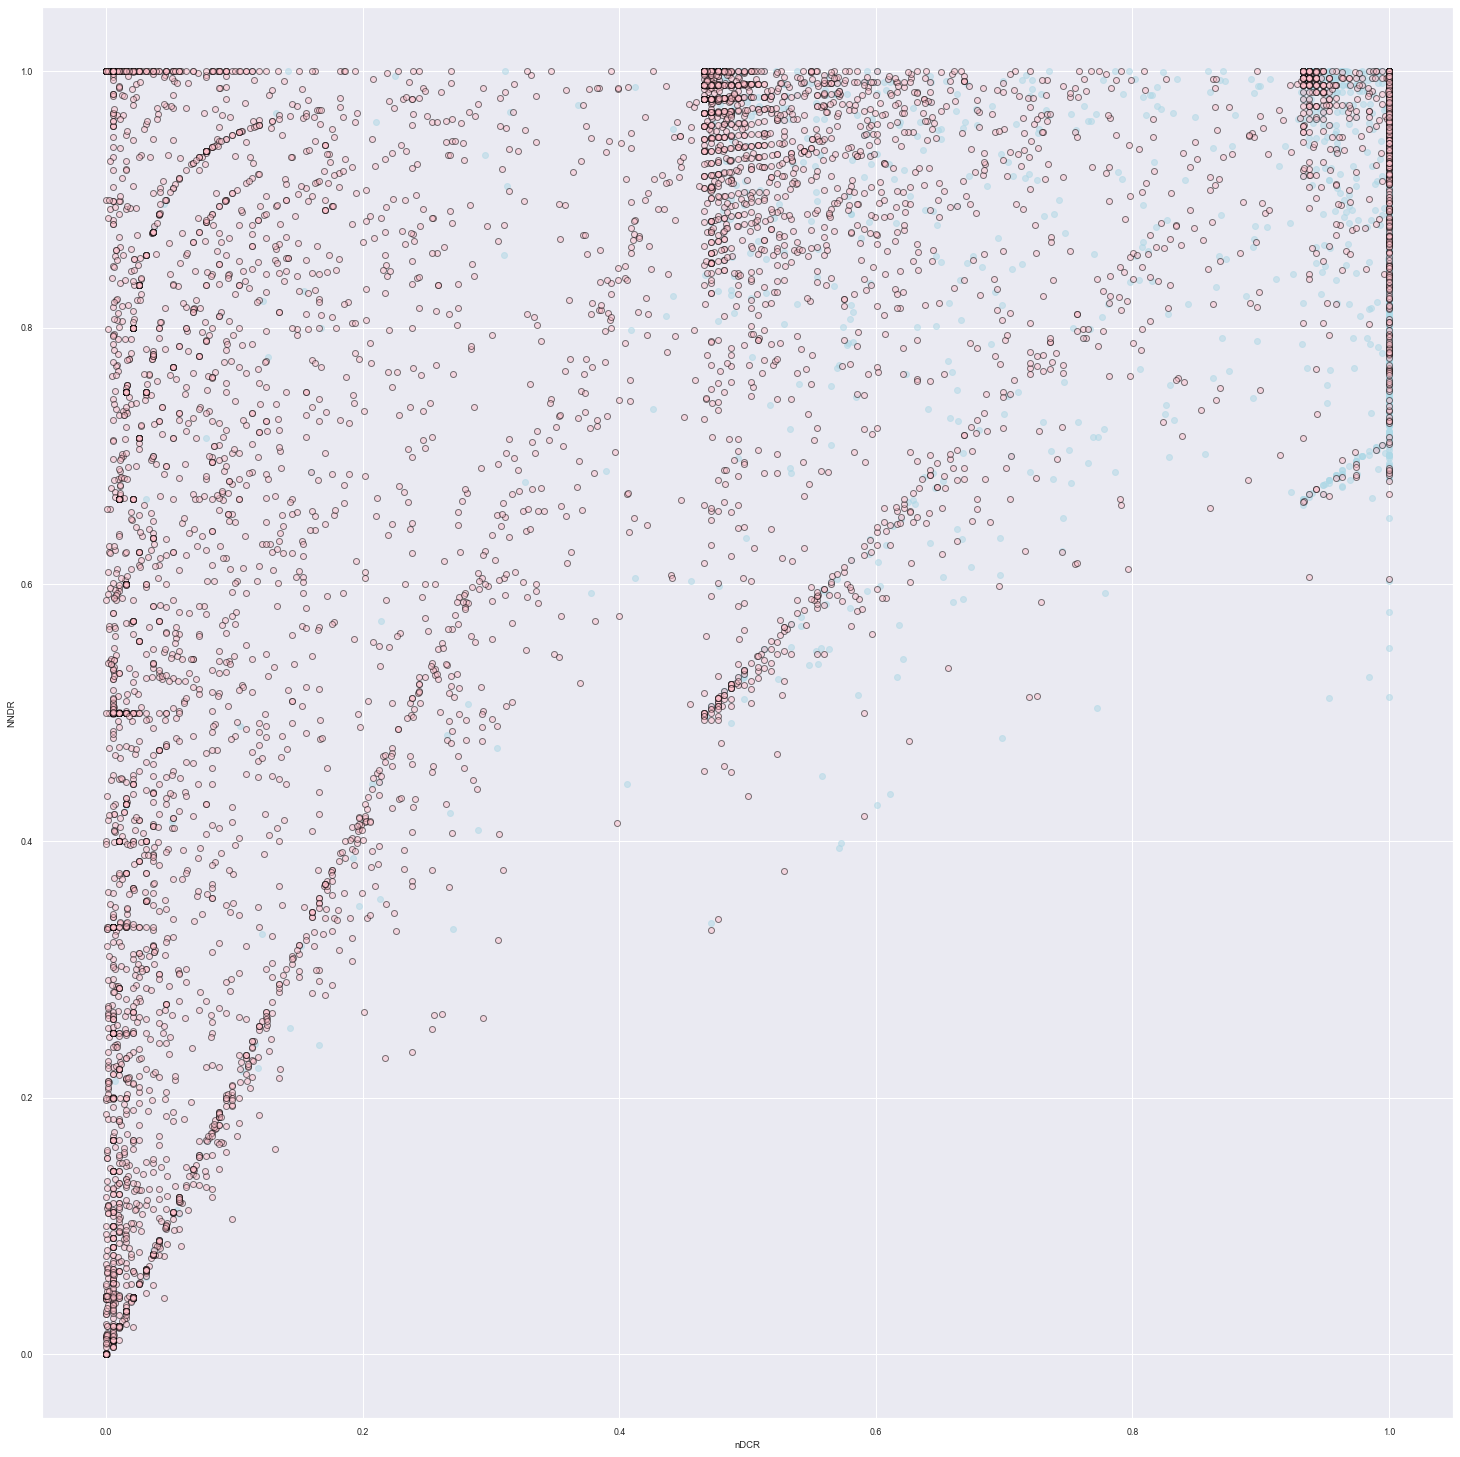

In [284]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [285]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

100.12359550561797

In [286]:
calc_nndr_ratio(nndr_real,nndr_synt1)

74.0

In [287]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=3779856.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=nan, p-value=nan
 Kolmogorov-Smirnov Test for nDCR: statistic=0.83566667, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.577556, p-value=0.000000


In [288]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [289]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [290]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [291]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [292]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [293]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.8825510834472359 0.2110492754640422 1.0 0.0 9000
nDCR stats 0.8660950119082398 0.27673479183168564 1.0 0.0 9000
DCR Bound 0.95 % = 6.019230769230769


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

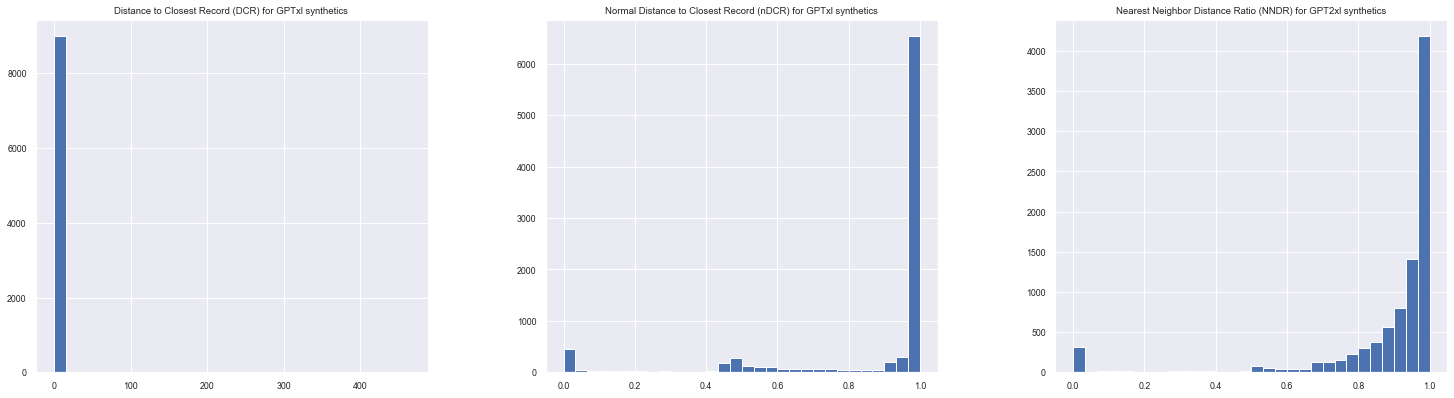

In [294]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

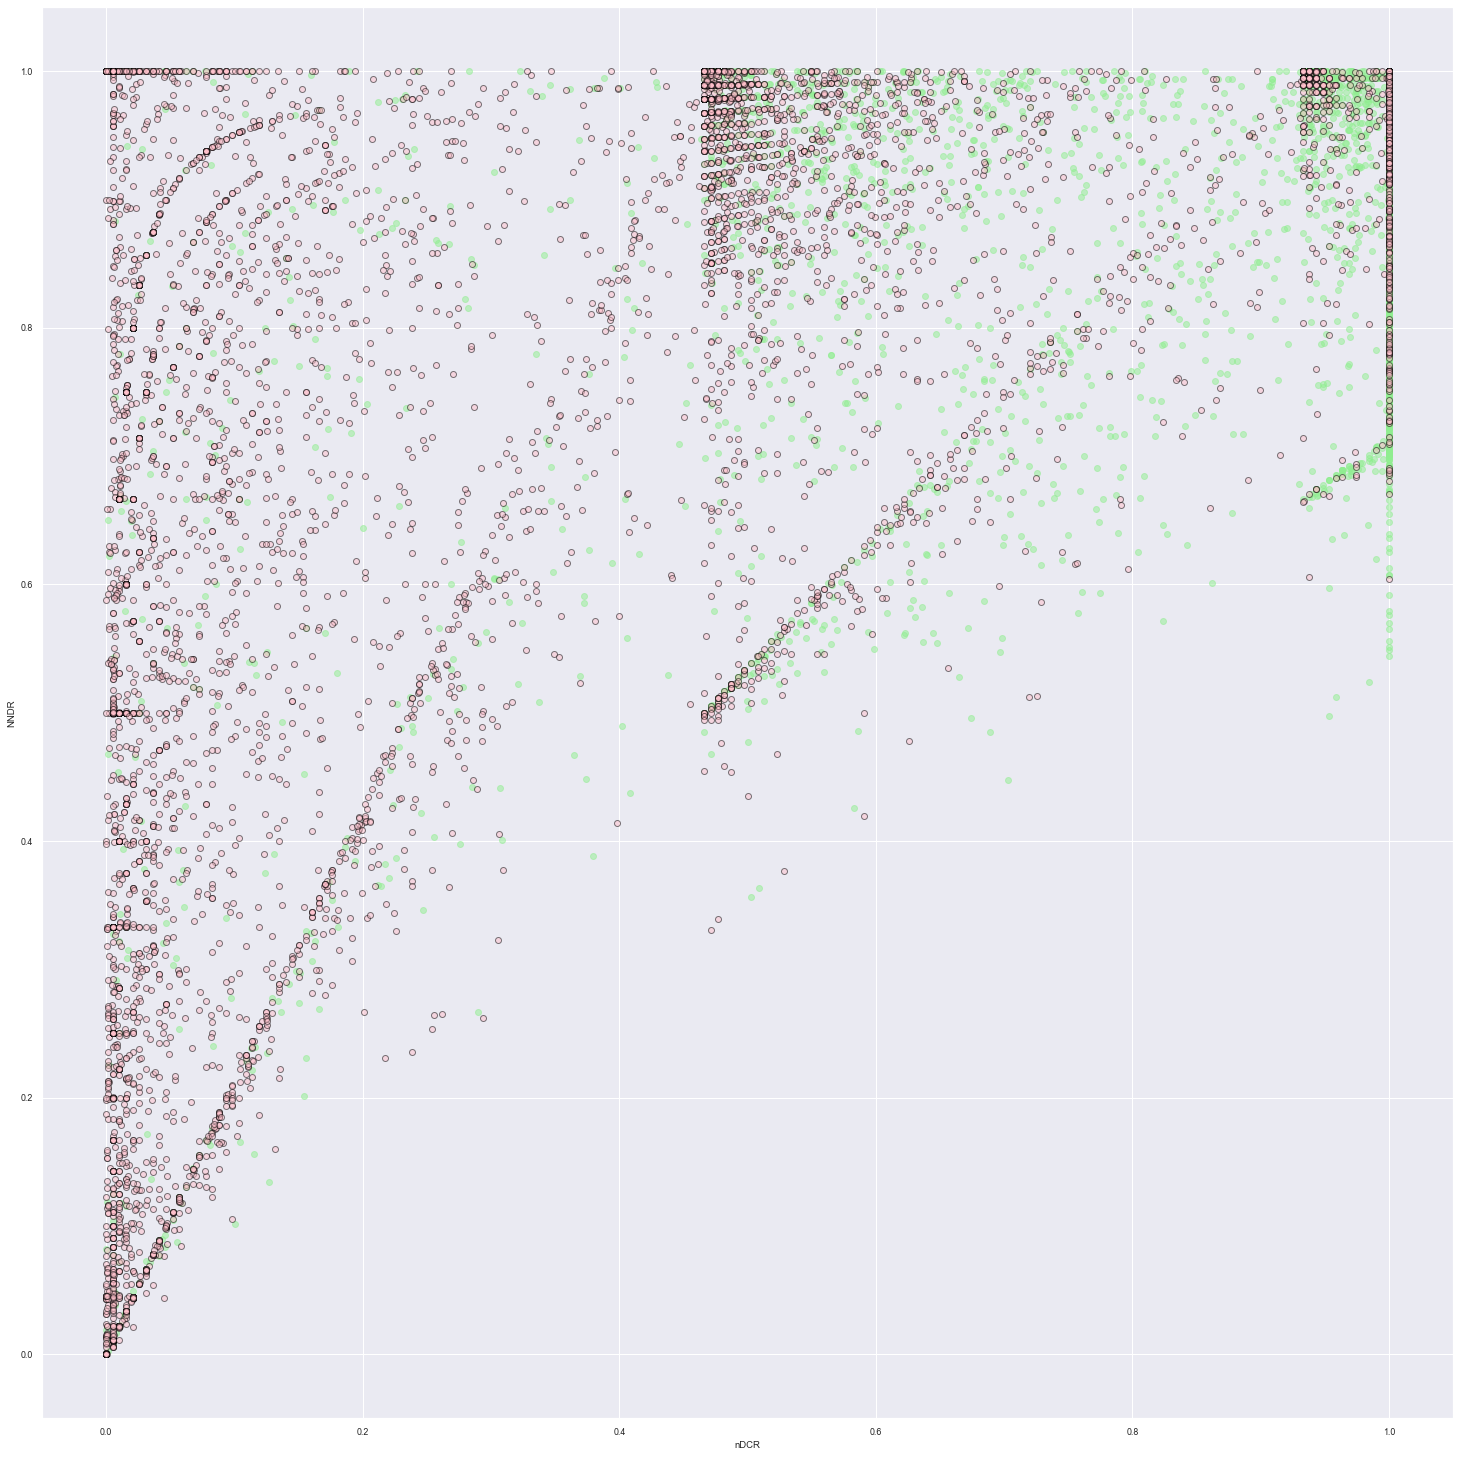

In [295]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [296]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

19.785219399538107

In [297]:
calc_nndr_ratio(nndr_real,nndr_synt2)

17.181818181818183

In [298]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=7713886.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=18232432.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.70722222, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.500556, p-value=0.000000


In [299]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [300]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [301]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [302]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [303]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [304]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.8759932962350124 0.22027025544192155 1.0 0.0 9000
nDCR stats 0.8538219367626119 0.2871354812822044 1.0 0.0 9000
DCR Bound 0.95 % = 5.971866239816244


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

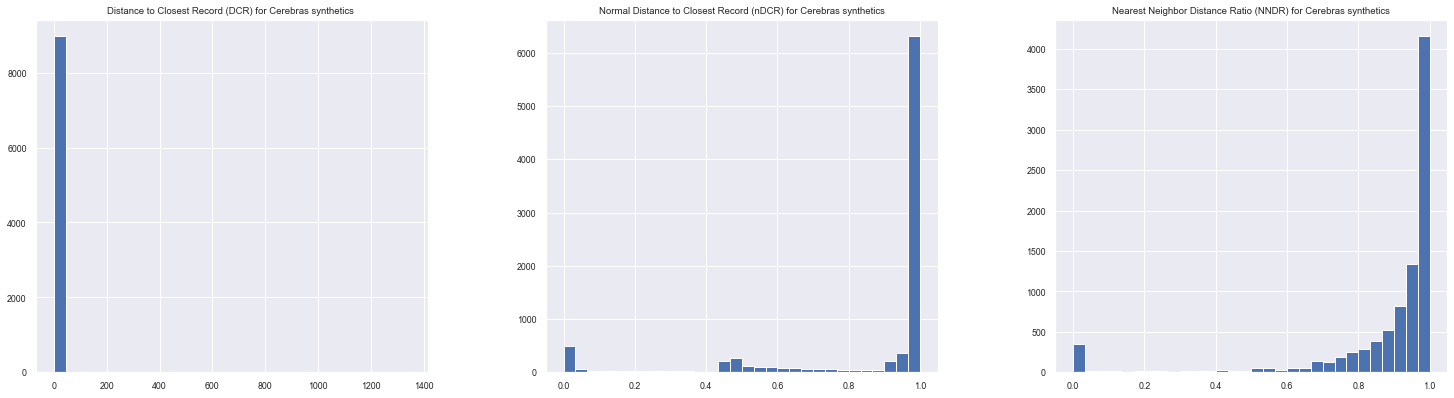

In [305]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

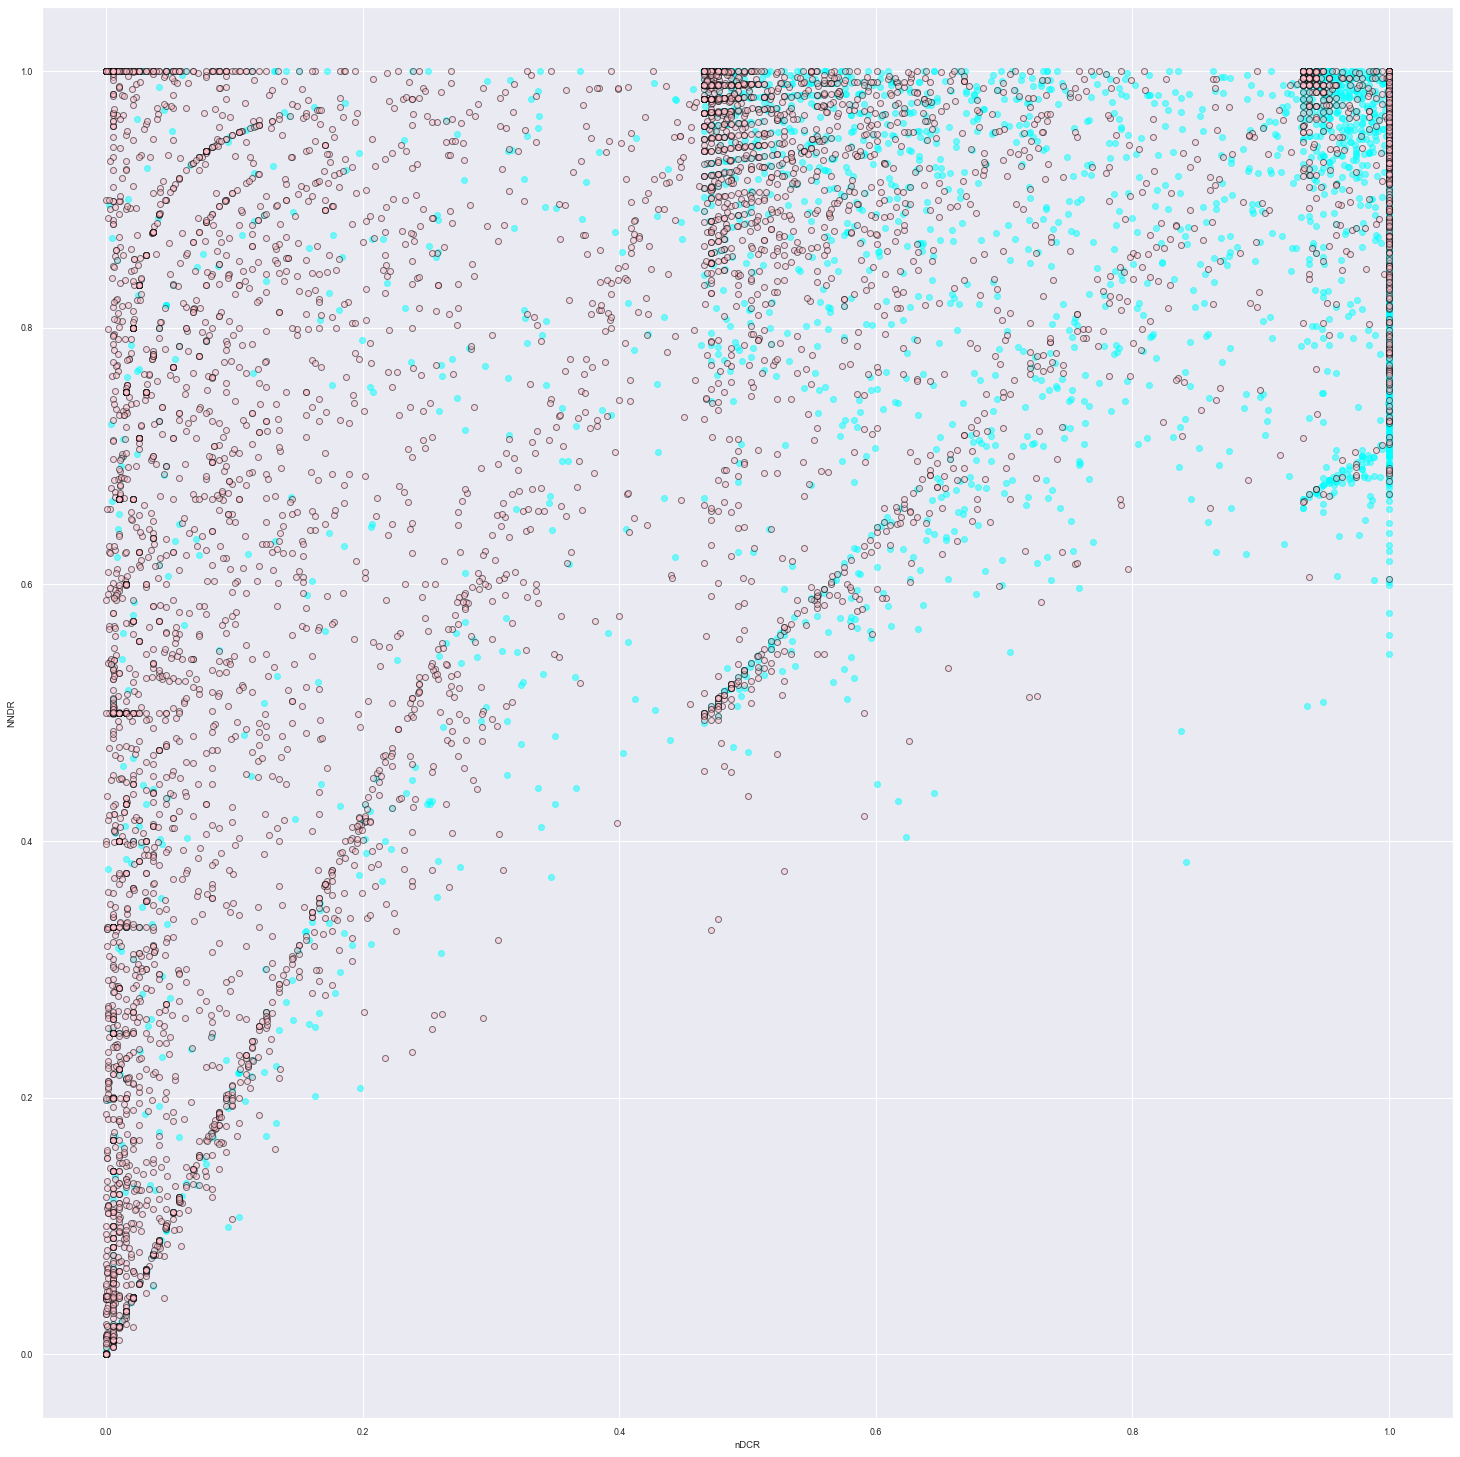

In [306]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [307]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

17.828451882845187

In [308]:
calc_nndr_ratio(nndr_real,nndr_synt3)

15.100178890876565

In [309]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=8260591.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=18616461.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.69111111, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.492111, p-value=0.000000


In [310]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [311]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [312]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [313]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [314]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [315]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.8754121212219677 0.2166757299399793 1.0 0.0 9000
nDCR stats 0.8548128040527119 0.28604023735906664 1.0 0.0 9000
DCR Bound 0.95 % = 5.77403846153846


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

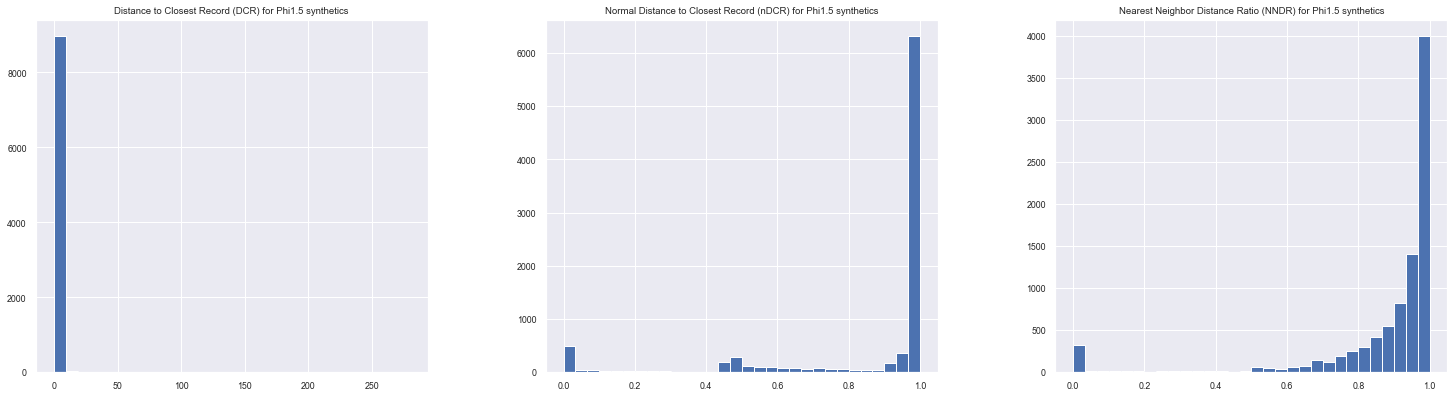

In [316]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

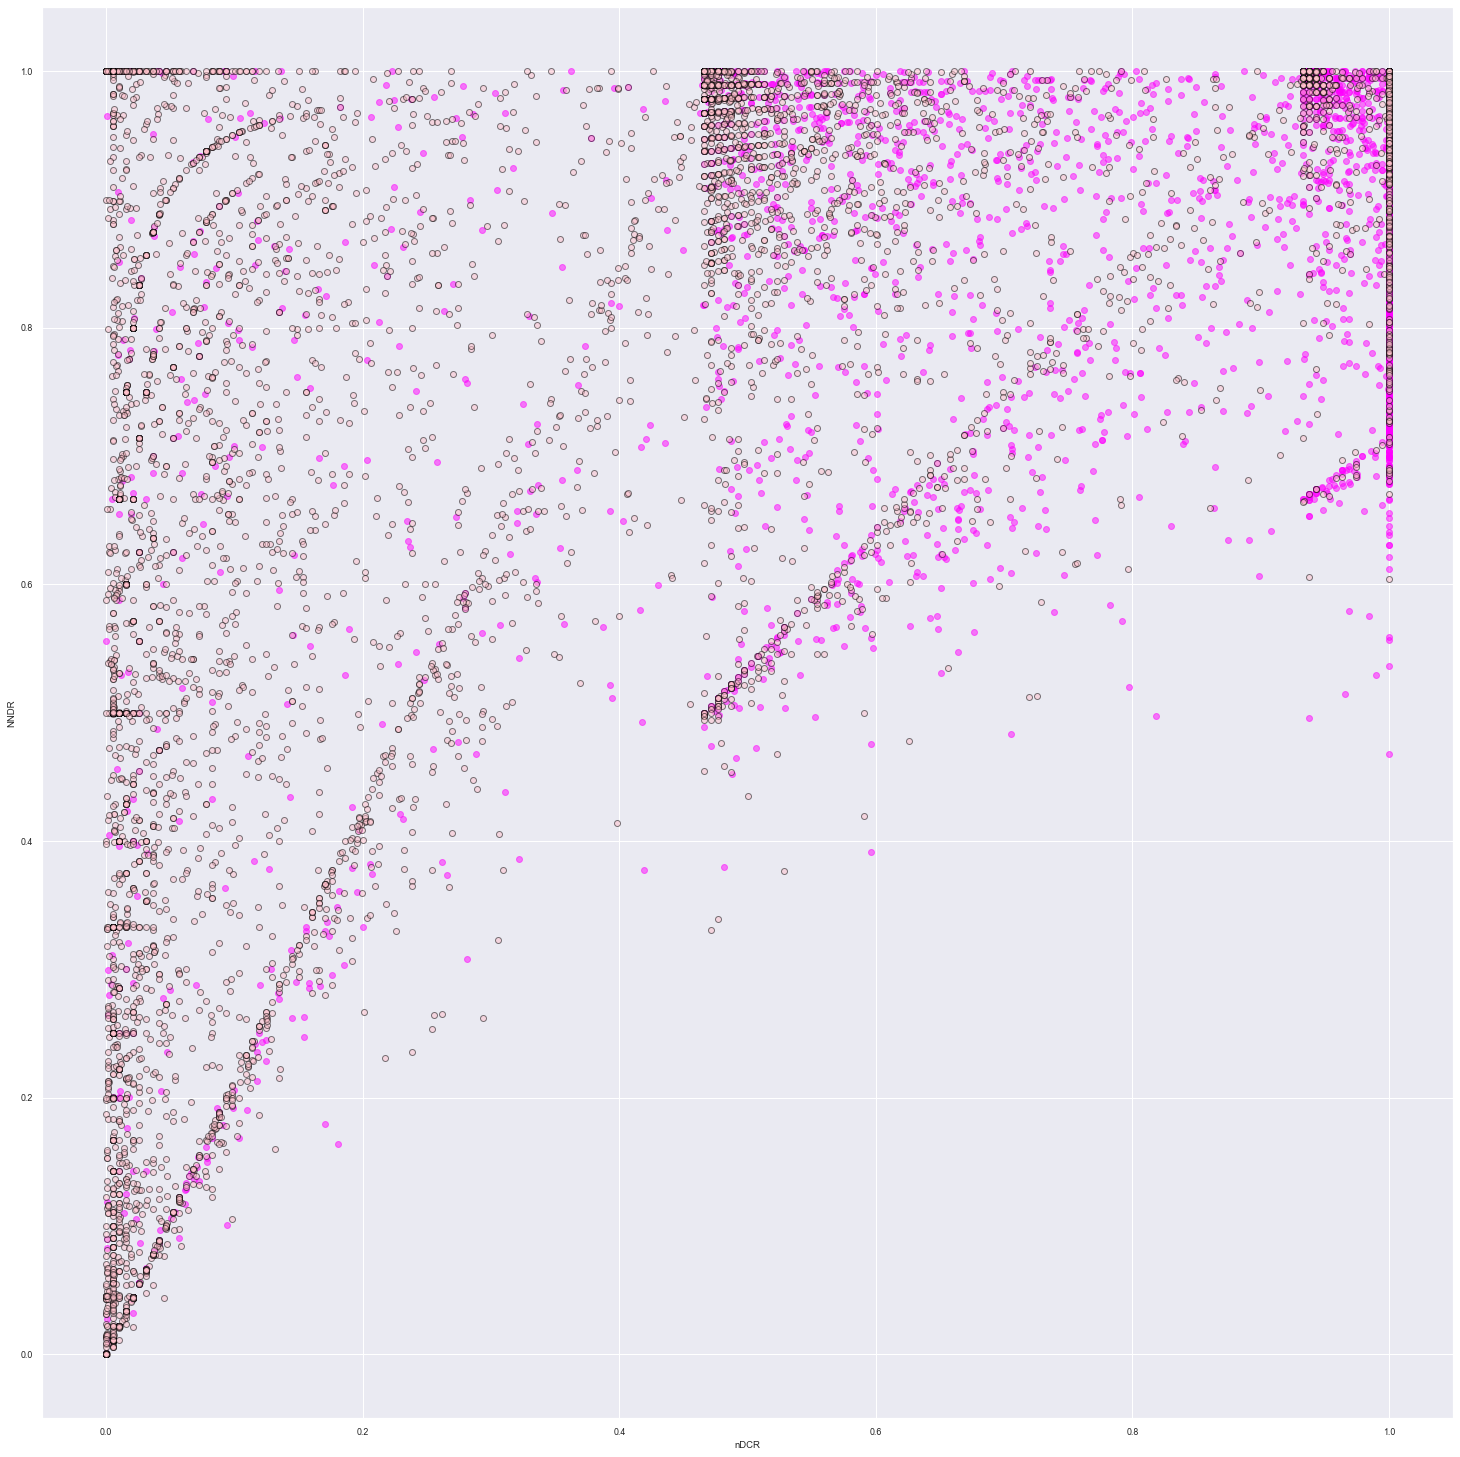

In [317]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [318]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

17.556701030927837

In [319]:
calc_nndr_ratio(nndr_real,nndr_synt4)

15.853932584269662

In [320]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=8161671.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=18800290.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.69355556, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.490667, p-value=0.000000


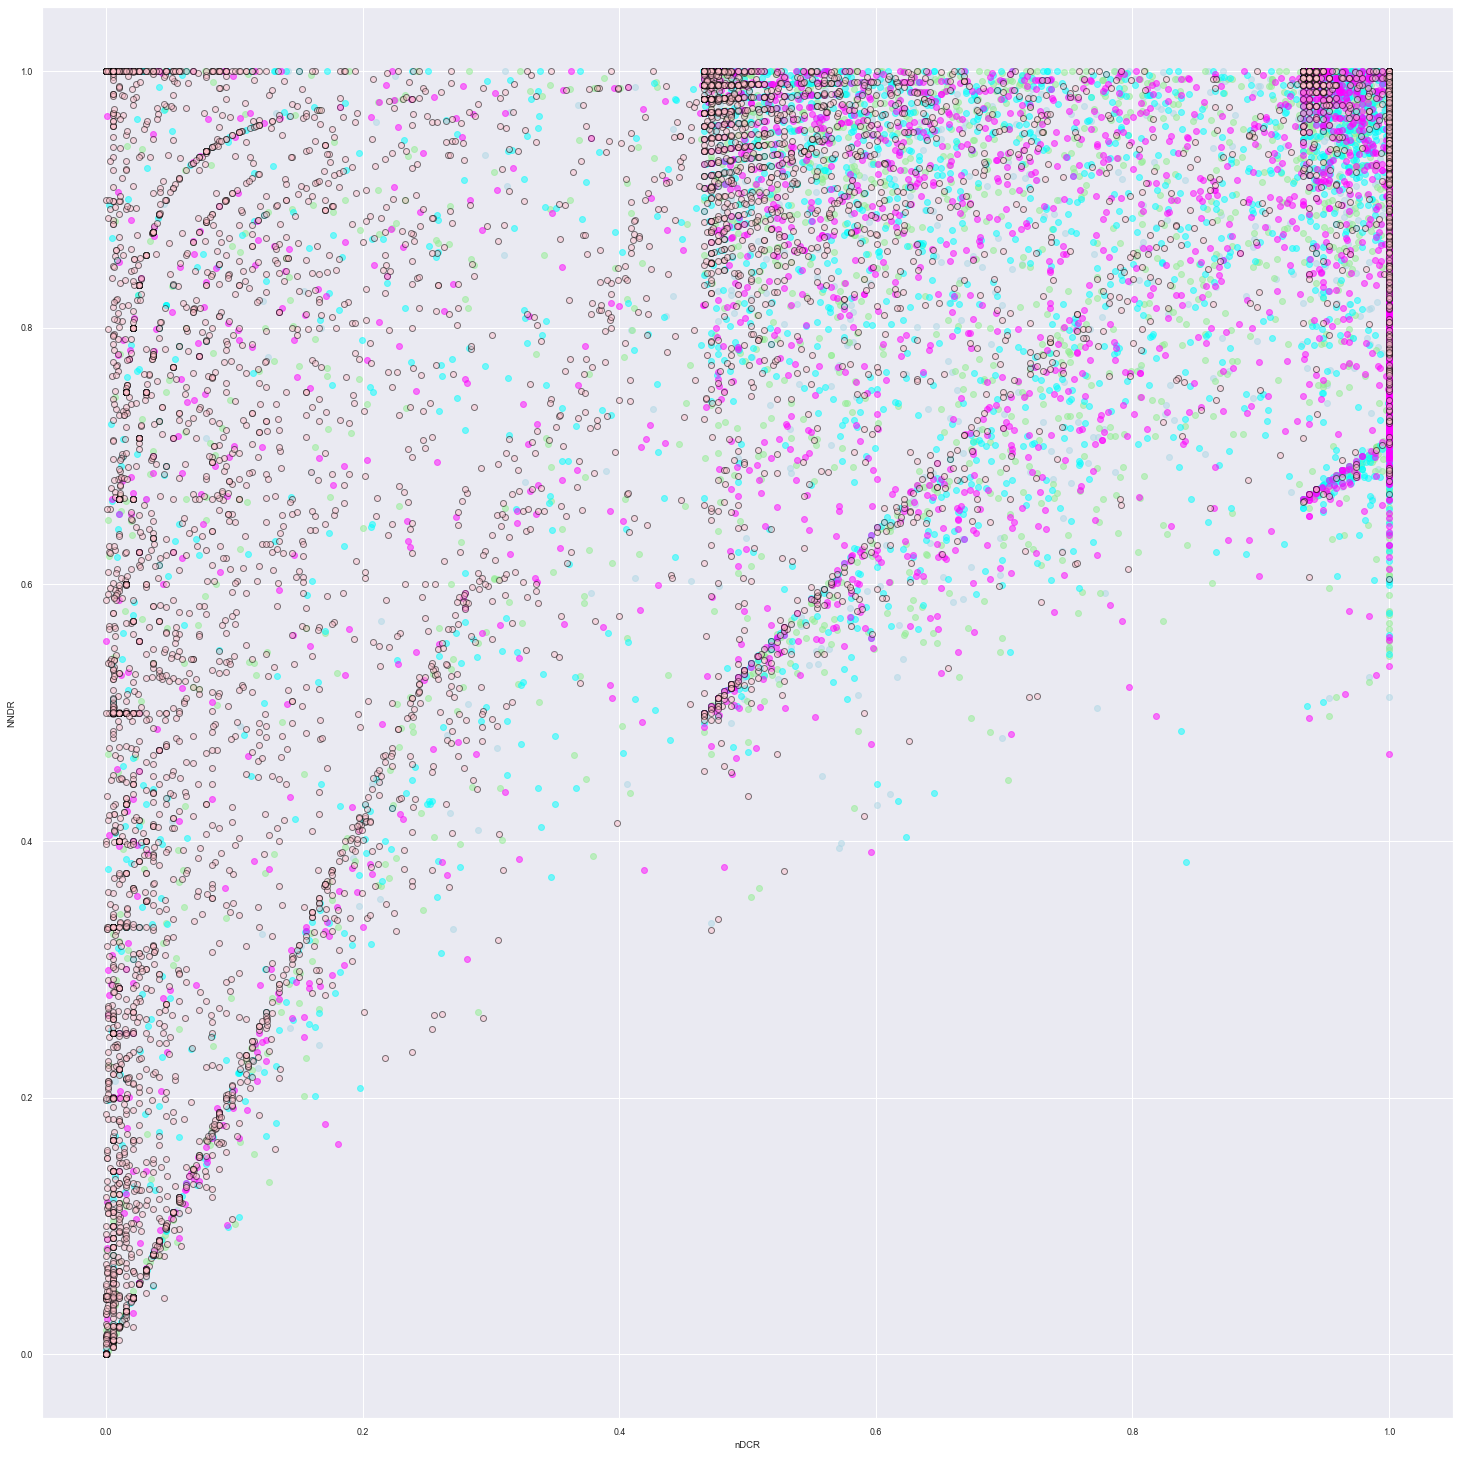

In [321]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [322]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [323]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   8.033400  100.123596   74.000000     1.000000          NaN   
0        GPT2xl   6.019231   19.785219   17.181818     1.000000     0.960469   
0      Cerebras   5.971866   17.828452   15.100179     1.000000     0.959220   
0        Phi1.5   5.774038   17.556701   15.853933     1.000000     0.956647   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [324]:
privacy_results.to_csv('privacy_results_shortincome_temp1.9.csv')